In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
from pprint import pprint

from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

import seaborn as sns
from mpl_toolkits import mplot3d
# import plotly.express as px
sns.set_style("whitegrid")

Traceback (most recent call last):
  File "/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


# Main Functions

In [5]:
def tree_analysis(current):
    """
    Analyze the result of tree builder
    Calculate: 1. Number of steps 2. \Pi plausibility 3. If find a path
    In case of celery error, all values are -1
    
    return:
        num_path = number of paths found
        status: Same as implemented in ASKCOS one
        num_step: number of steps
        p_score: \Pi plausibility
        synthesizability: binary code
        price: price for synthesize query compound
    """
    if 'error' in current.keys():
        return -1, {}, 11, -1, -1, -1
    
    if 'price' in current.keys():
        return 0, {}, 0, 1, 1, current['price']
    
    num_path = len(current['trees'])
    if num_path != 0:
        current = [current['trees'][0]]
        if current[0]['ppg'] != 0:
            return 0, {}, 0, 1, 1, current[0]['ppg']
    else:
        current = []
        
    depth = 0
    p_score = 1
    status = {0:1}
    price = 0
    while True:
        
        num_child = 0
        depth += 0.5
        temp = []
        
        for i, item in enumerate(current):
            num_child += len(item['children'])
            temp = temp + item['children']
            
        if num_child == 0:
            break
            
        if depth % 1 != 0:
            for sth in temp:
                p_score = p_score * sth['plausibility']
        else:
            for mol in temp:
                price += mol['ppg']
        
        status[depth] = num_child
        current = temp
        
    if len(status) > 1:
        synthesizability = 1
    else:
        synthesizability = 0
        
    if int(depth - 0.5) == 0:
        depth = 11
        price = -1
    else:
        depth = int(depth - 0.5)
        
    return num_path, status, depth, p_score*synthesizability, synthesizability, price

In [118]:
results = []
csv_file = 'datasets/sheridan_all.csv'
name = csv_file.split('.')[0]
df_file = pd.read_csv(csv_file)
num = len(df)
for i in range(num):
    json_file = name + '_' + str(i) + '.json'
    if os.path.exists(json_file):
        with open(json_file) as f:
            results.append(json.load(f))
            
num = len(results)

depths = []
p_scores = []
synthesizabilitys = []
smiles = []
prices = []
for i in range(num):
    smiles.append(results[i]['request']['smiles'][0])
    num_path, status, depth, p_score, synthesizability, price = tree_analysis(results[i])
    depths.append(depth)
    p_scores.append(p_score)
    synthesizabilitys.append(synthesizability)
    prices.append(price)
        
df = pd.DataFrame({
    'SMILES': smiles,
    'tb_synthesizability': synthesizabilitys,
    'tb_depth': depths,
    'tb_plausibility': p_scores,
    'tb_price': prices
})
df.head()

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price
0,CN(C)CCCN1c2ccccc2CCc2ccccc12,1,0,1.0,7.0
1,CC(C)NC[C@@H](O)COc1ccc(CC(=O)N)cc1,1,0,1.0,24.0
2,C[C@@H](CCc1ccccc1)NC[C@@H](O)c1ccc(O)c(c1)C(=O)N,1,0,1.0,10.0
3,Nc1ccc(cc1)S(=O)(=O)Nc1nccs1,1,0,1.0,1.0
4,CCC[C@@H](C)C1(CC=C)C(=O)NC(=S)NC1=O,1,0,1.0,8.0


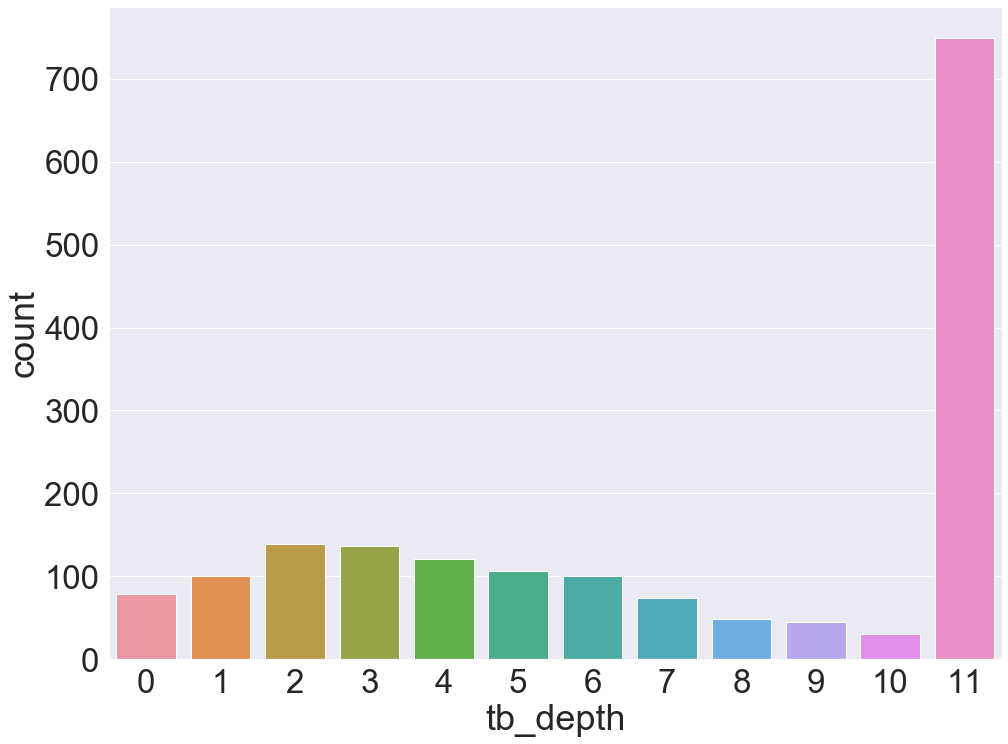

In [119]:
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df)
# fig.savefig('./count.png')

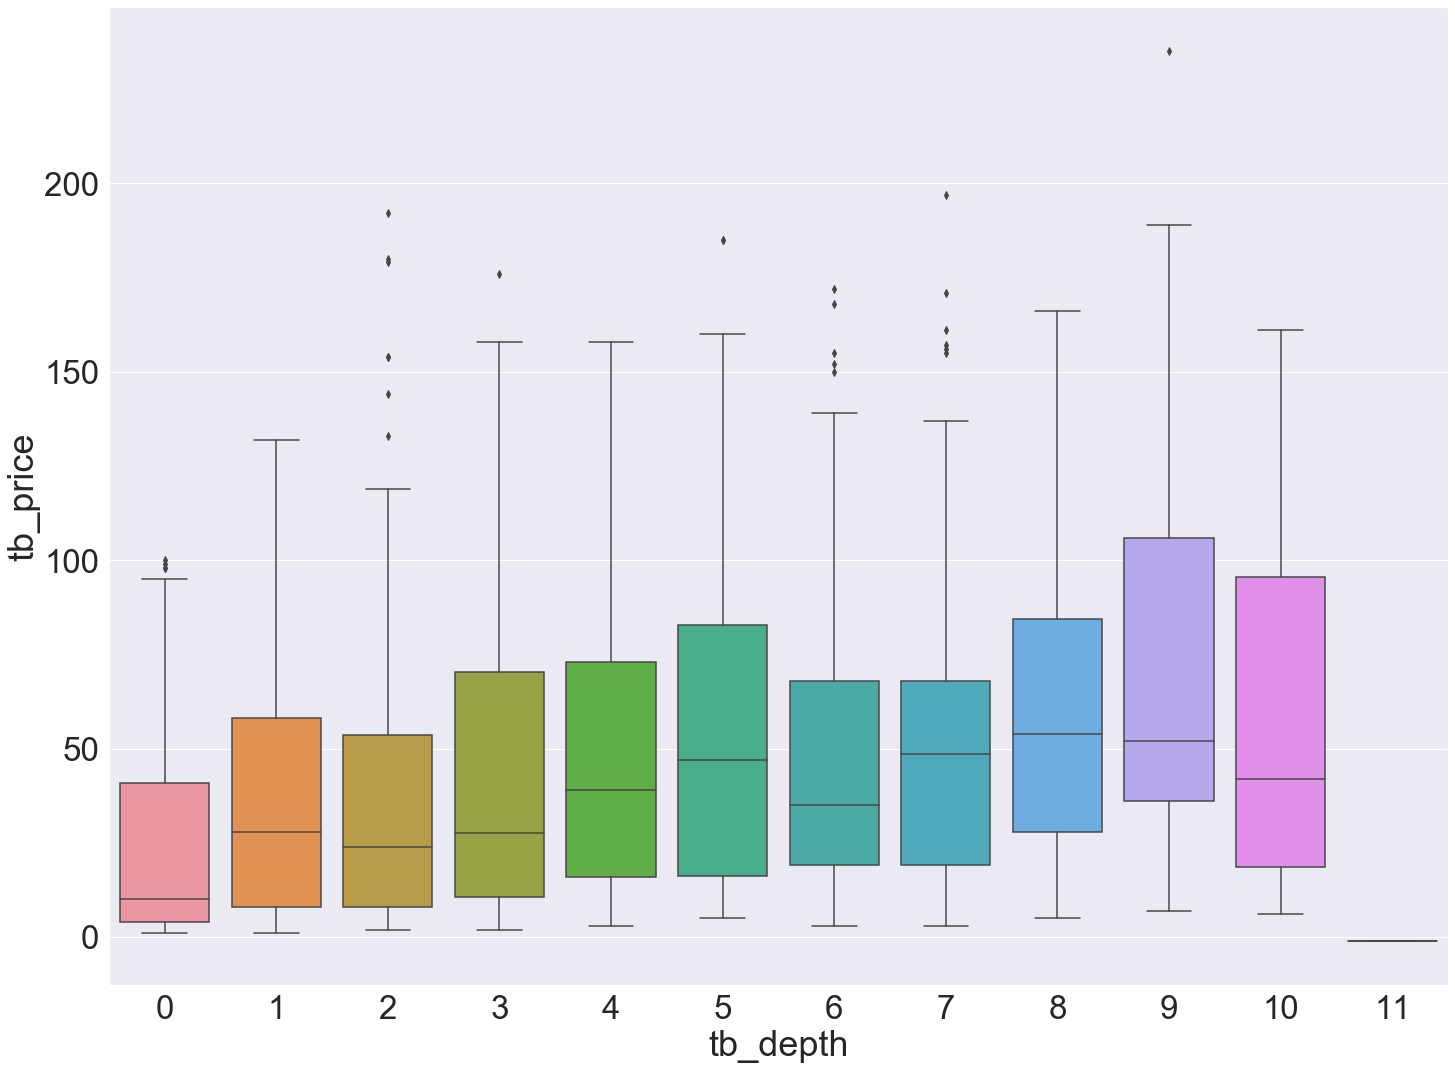

In [120]:
fig = plt.figure(figsize=[24, 18])
sns.set(font_scale=3)
ax = sns.boxplot(x="tb_depth", y="tb_price", data=df)
# fig.savefig('./sheridan_price_depth.png')

In [121]:
df_original = pd.read_csv('../synth_gen/sas_test/sheridan.csv')
mc = list(df_original.meanComplexity)[:1730]
sc_score = list(df_original['SCScore (us)'])[:1730]
sa_score = list(df_original['SAScore (Ertl, in RDKit)'])[:1730]

In [122]:
df['mean_complexity'] = mc
df['sa_score'] = sa_score
df['sc_score'] = sc_score
df['len_smiles'] = df.SMILES.apply(len)

/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


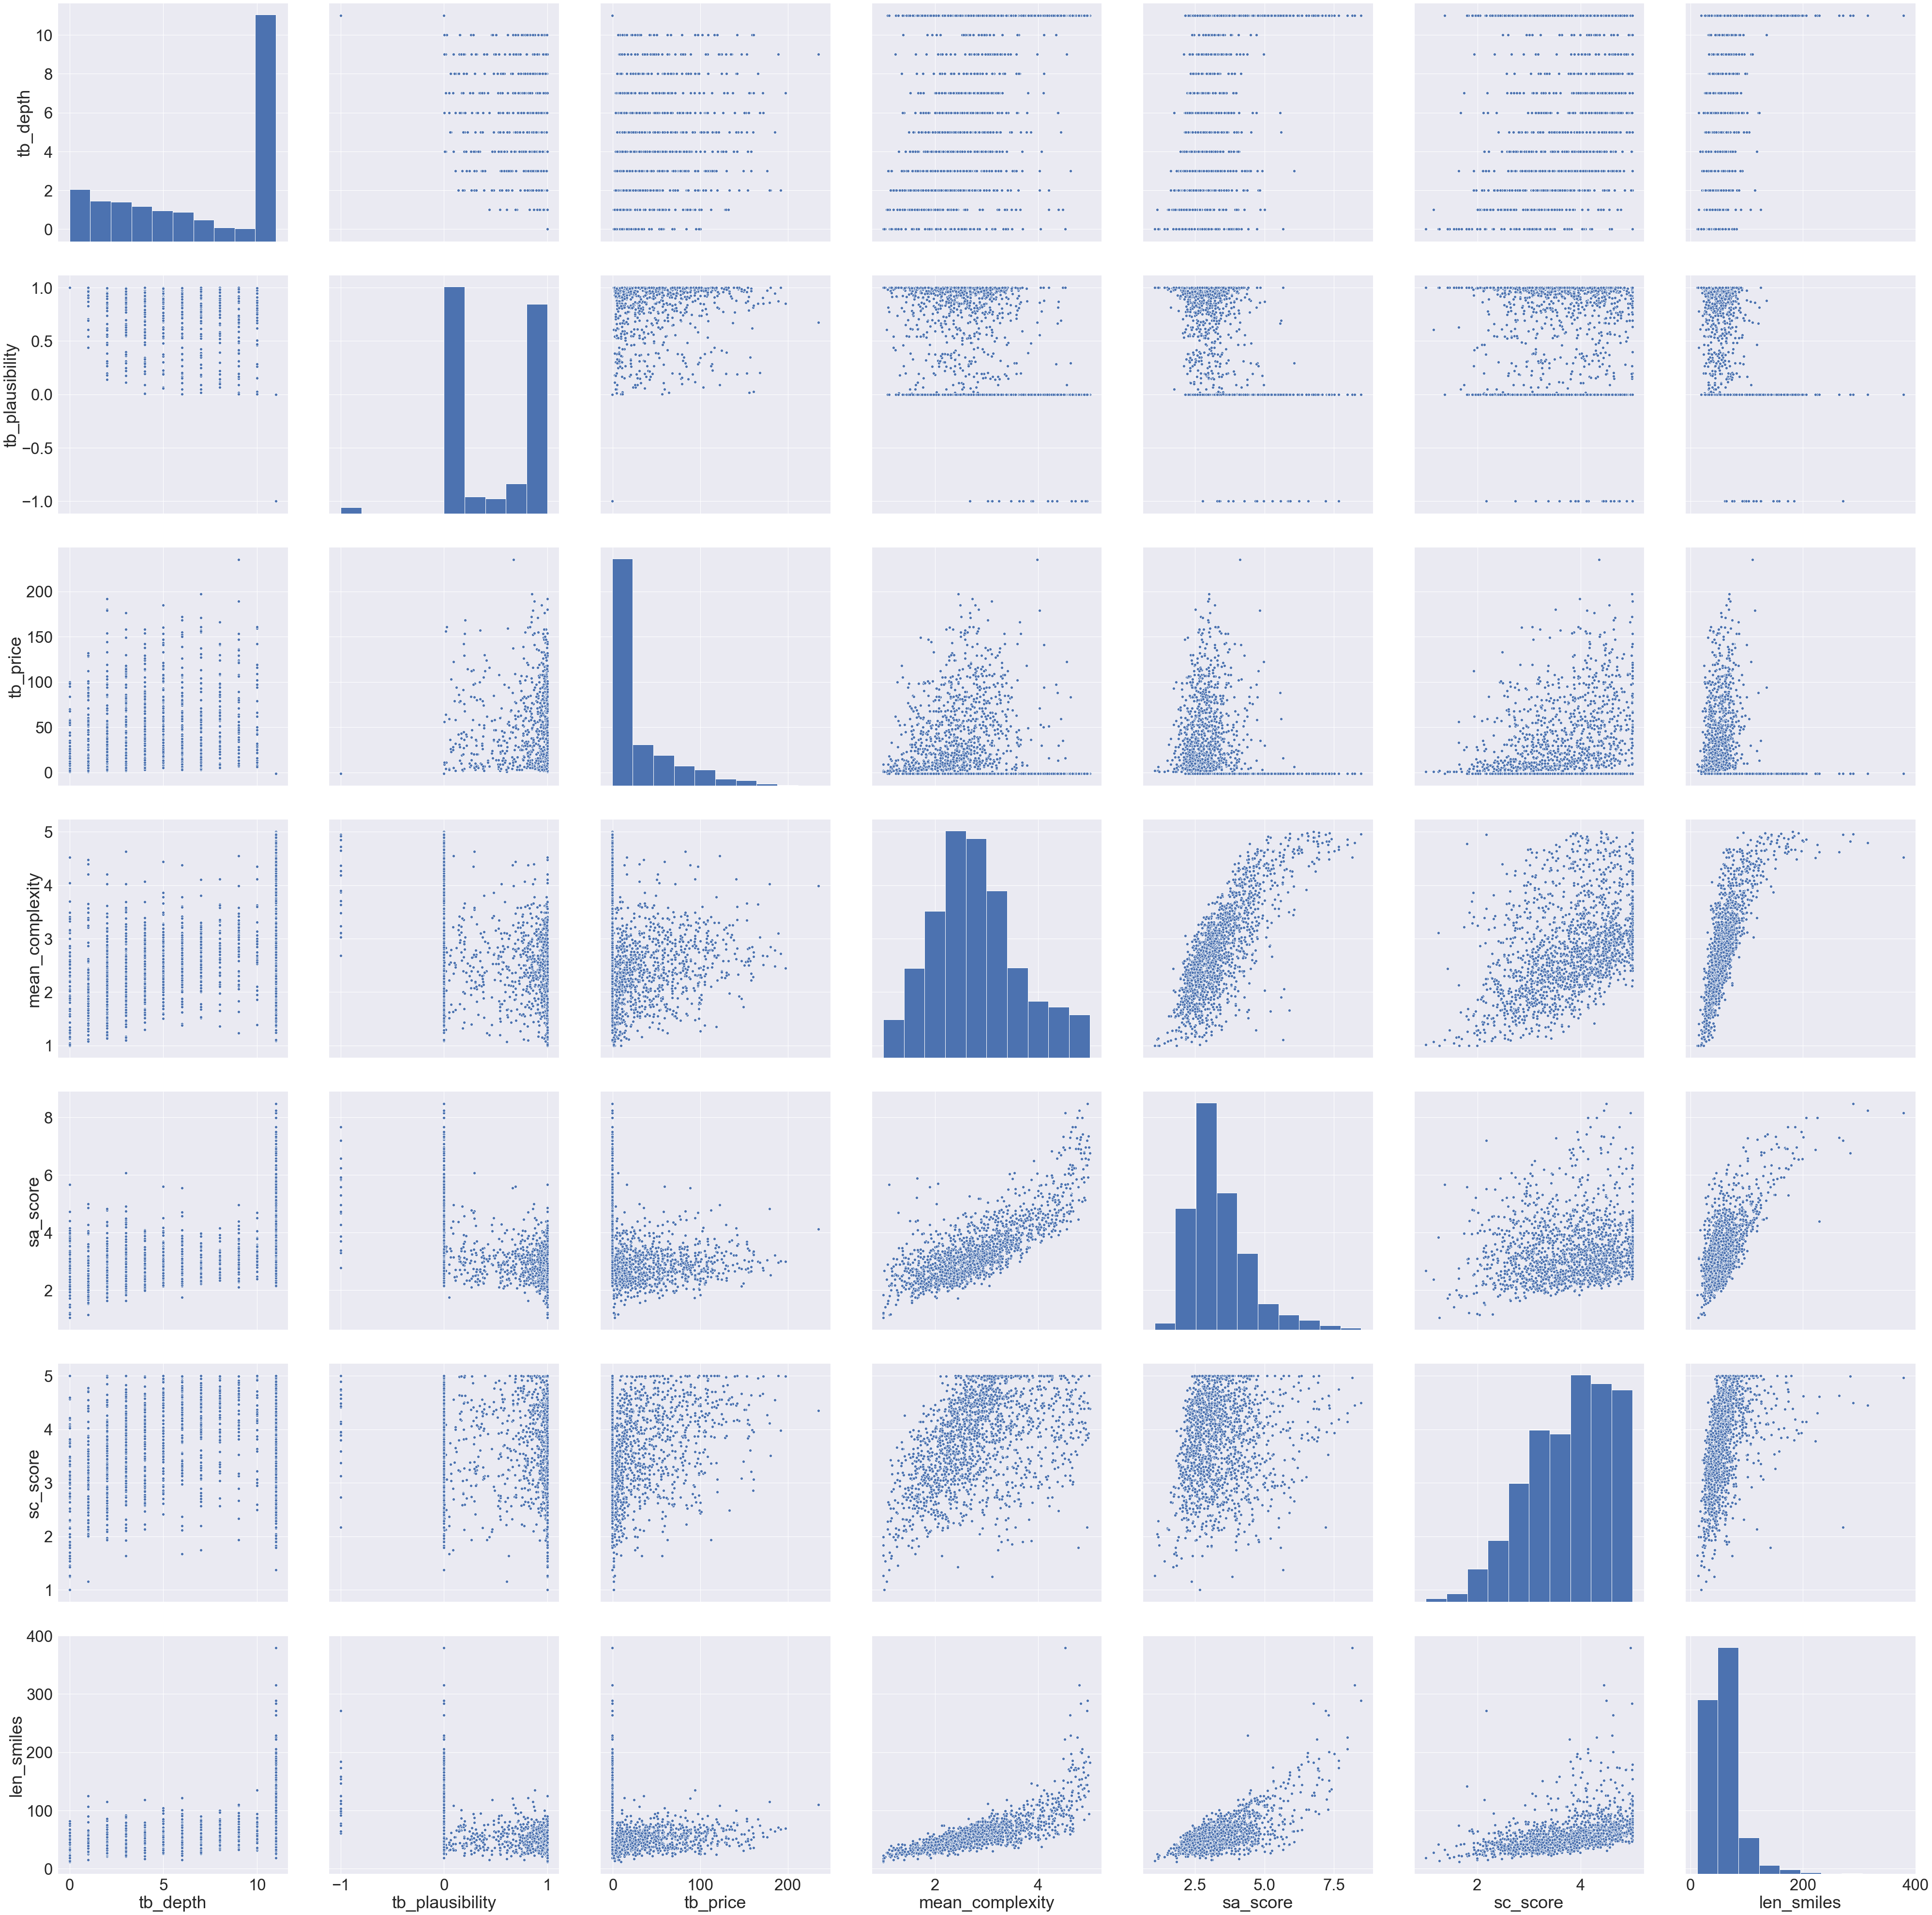

In [104]:
sns.set(font_scale=3)
g = sns.pairplot(df, vars=["tb_depth", "tb_plausibility", "tb_price", "mean_complexity", "sa_score", "sc_score", "len_smiles"], size=8)

<Figure size 1728x1296 with 0 Axes>

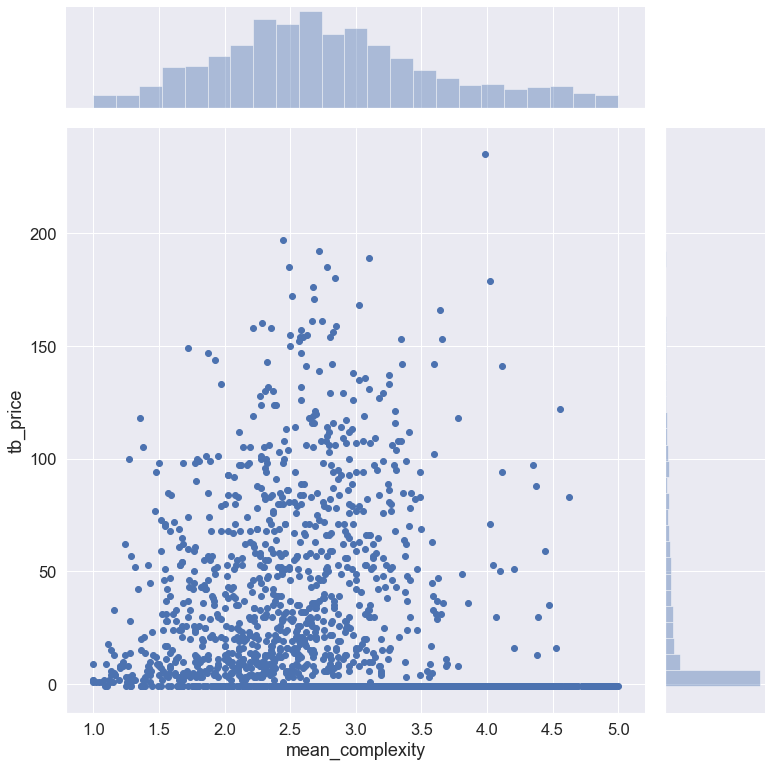

In [114]:
fig = plt.figure(figsize=[24, 18])
sns.set(font_scale=1.5)
g = sns.jointplot(x="mean_complexity", y="tb_price", data=df, size=11)

In [125]:
df_sheridan = df
df_sheridan.to_csv('./done_sheridan.csv', index=False)

In [6]:
def process_data(csv_file):
    results = []
    name = csv_file.split('.')[0]
    df_file = pd.read_csv(csv_file)
    num = len(df_file)
    for i in range(num):
        json_file = name + '_' + str(i) + '.json'
        if os.path.exists(json_file):
            with open(json_file) as f:
                results.append(json.load(f))

    num_temp = len(results)

    depths = []
    p_scores = []
    synthesizabilitys = []
    smiles = df_file.SMILES
    prices = []
    for i in range(num_temp):
#         smiles.append(results[i]['request']['smiles'][0])
        num_path, status, depth, p_score, synthesizability, price = tree_analysis(results[i])
        depths.append(depth)
        p_scores.append(p_score)
        synthesizabilitys.append(synthesizability)
        prices.append(price)
        
    for i in range(num - num_temp):
        depths.append(-1)
        p_scores.append(-1)
        synthesizabilitys.append(-1)
        prices.append(-1)
    
    df = pd.DataFrame({
        'SMILES': smiles,
        'tb_synthesizability': synthesizabilitys,
        'tb_depth': depths,
        'tb_plausibility': p_scores,
        'tb_price': prices,
#         'sa_score': df_file.sa_score,
#         'sc_score': df_file.sc_score
    })
    
    df['len_smiles'] = df.SMILES.apply(len)
    
    return df
    

# Process!

In [149]:
path_to_file = 'datasets/moses_3k.csv'
df_moses = process_data(path_to_file)

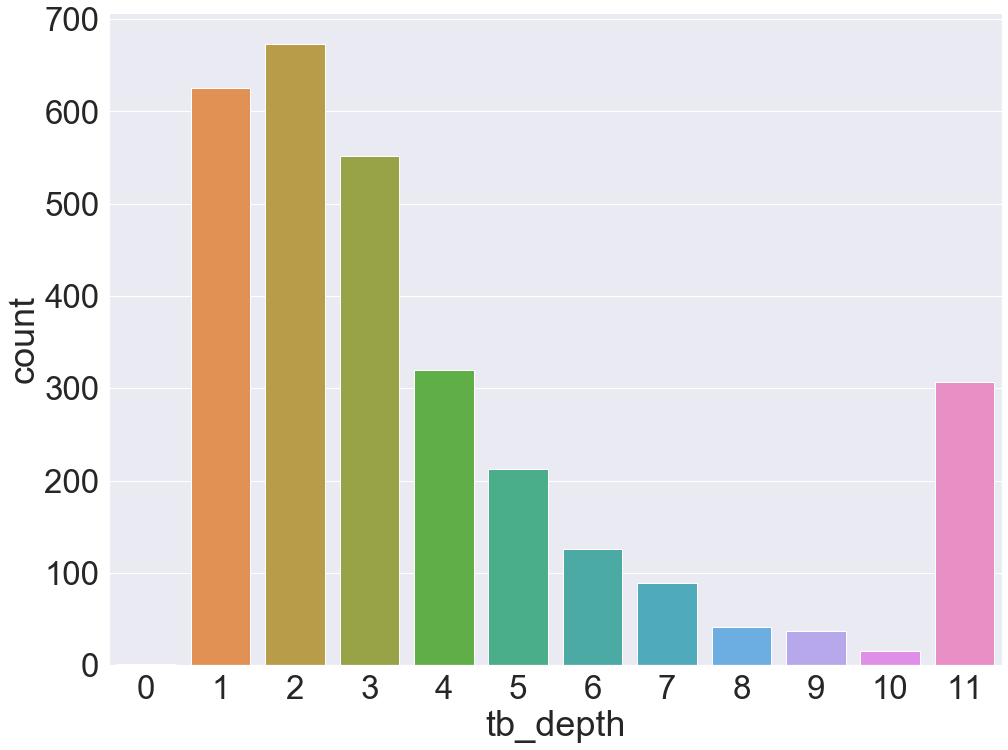

In [150]:
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses)

In [151]:
path_to_file = 'datasets/guacamol_3k.csv'
df_guacamol = process_data(path_to_file)

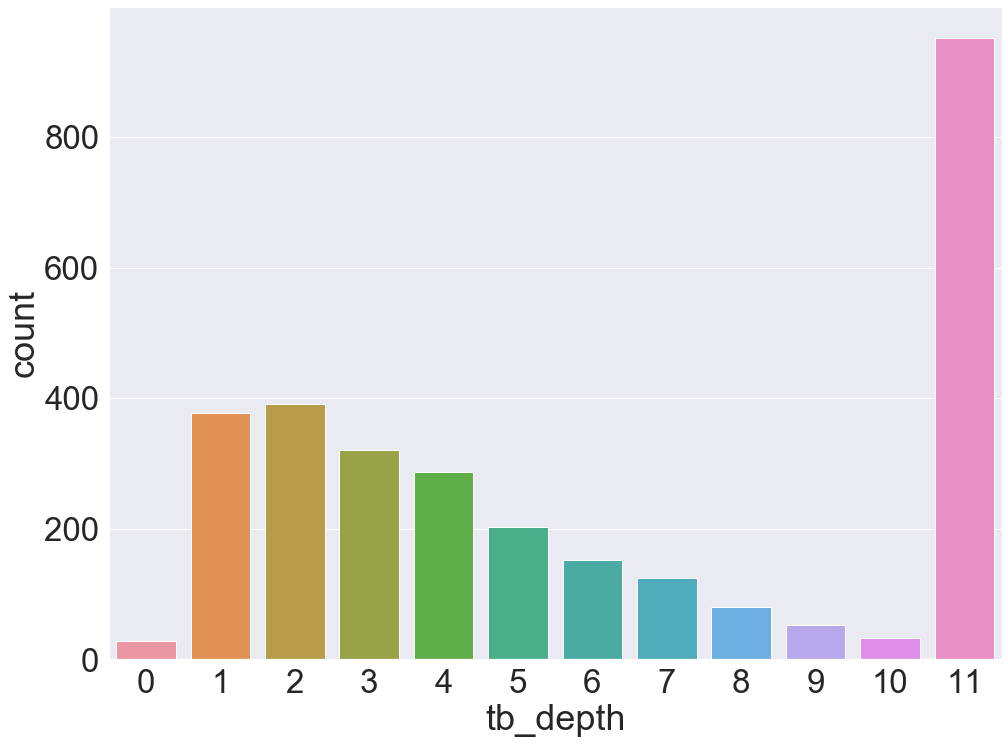

In [152]:
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_guacamol)

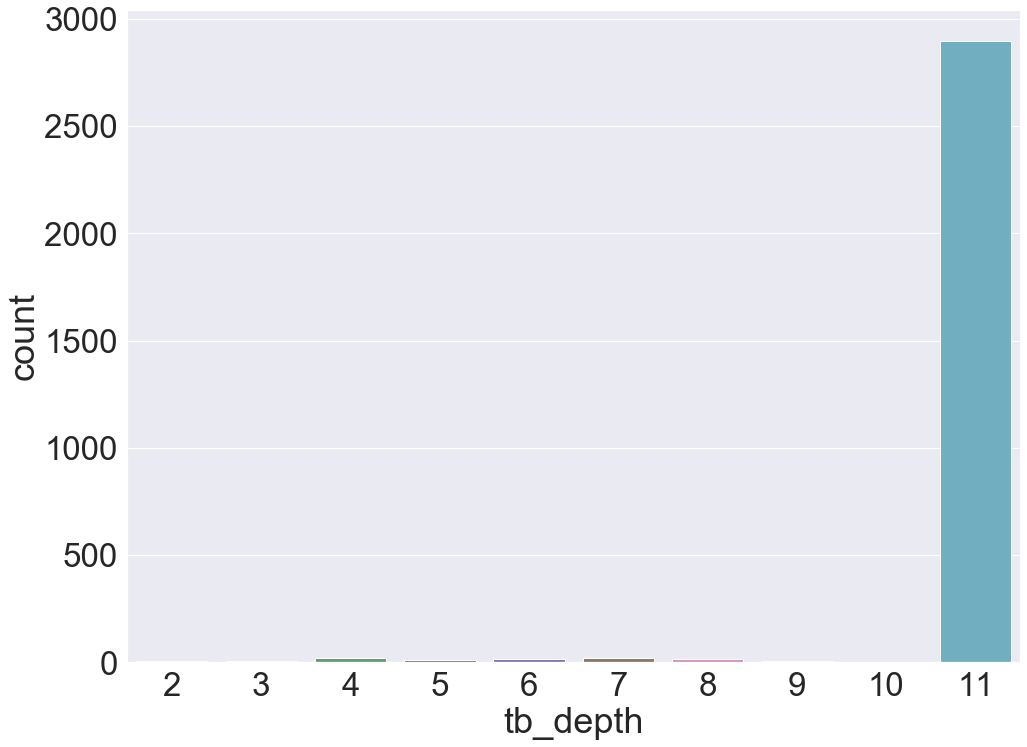

In [204]:
path_to_file = 'datasets/gdb_3k.csv'
df_gdb = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_gdb)

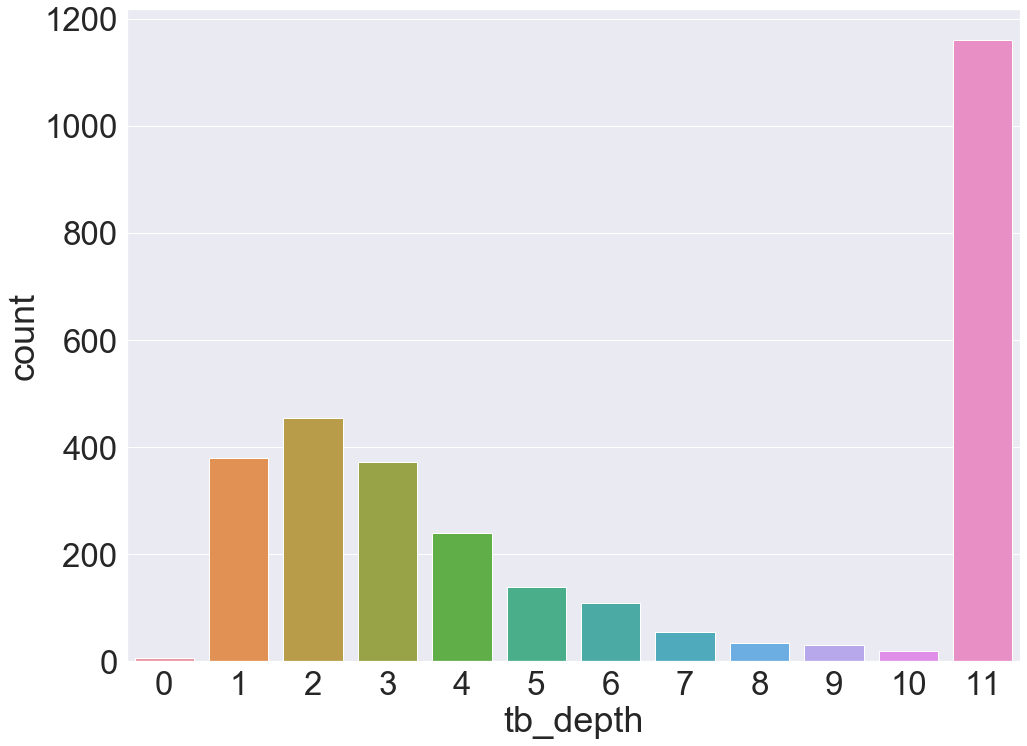

In [7]:
path_to_file = 'datasets/zinc_3k.csv'
df_zinc = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_zinc)

In [10]:
# df_moses.to_csv('./done_moses.csv', index=False)
# df_guacamol.to_csv('./done_guacamol.csv', index=False)
df_zinc.to_csv('./done_zinc.csv', index=False)
# df_gdb.to_csv('./done_gdb.csv', index=False)

In [9]:
# df_moses['dataset'] = 'moses'
# df_guacamol['dataset'] = 'guacamol'
df_zinc['dataset'] = 'zinc'
# df_gdb['dataset'] = 'gdb'

In [213]:
df_dataset = pd.concat([df_moses, df_guacamol, df_zinc, df_gdb])

/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [214]:
df_dataset.to_csv('./datasets.csv', index=False)

# Distribution Learning

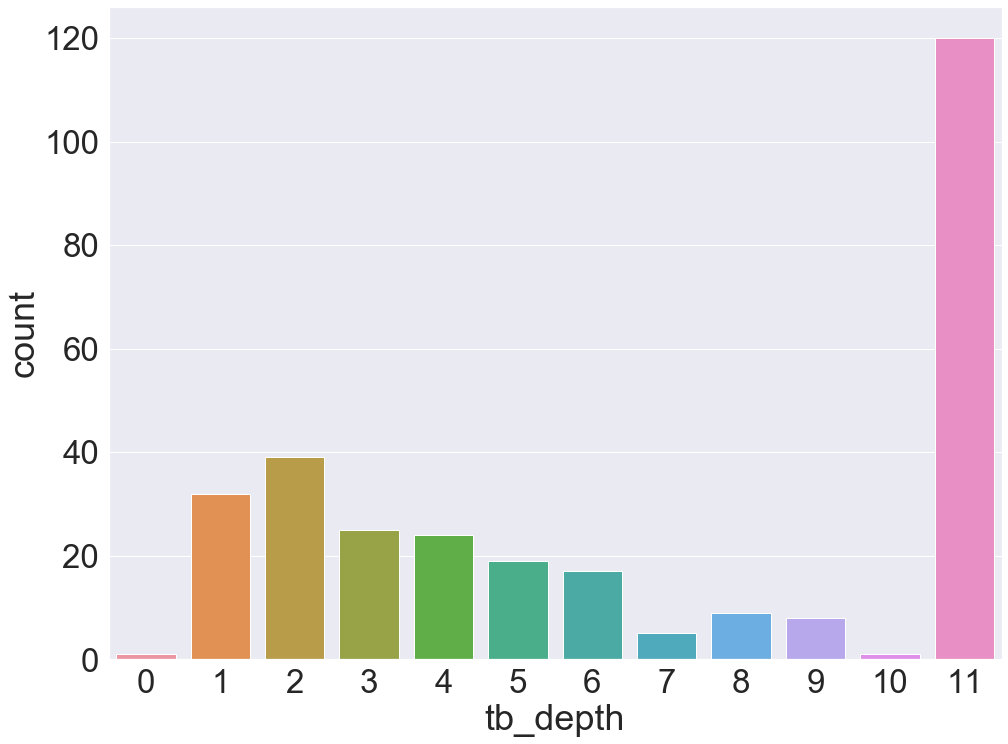

In [11]:
path_to_file = 'dl_chembl/vae.csv'
df_chembl_vae = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_vae)

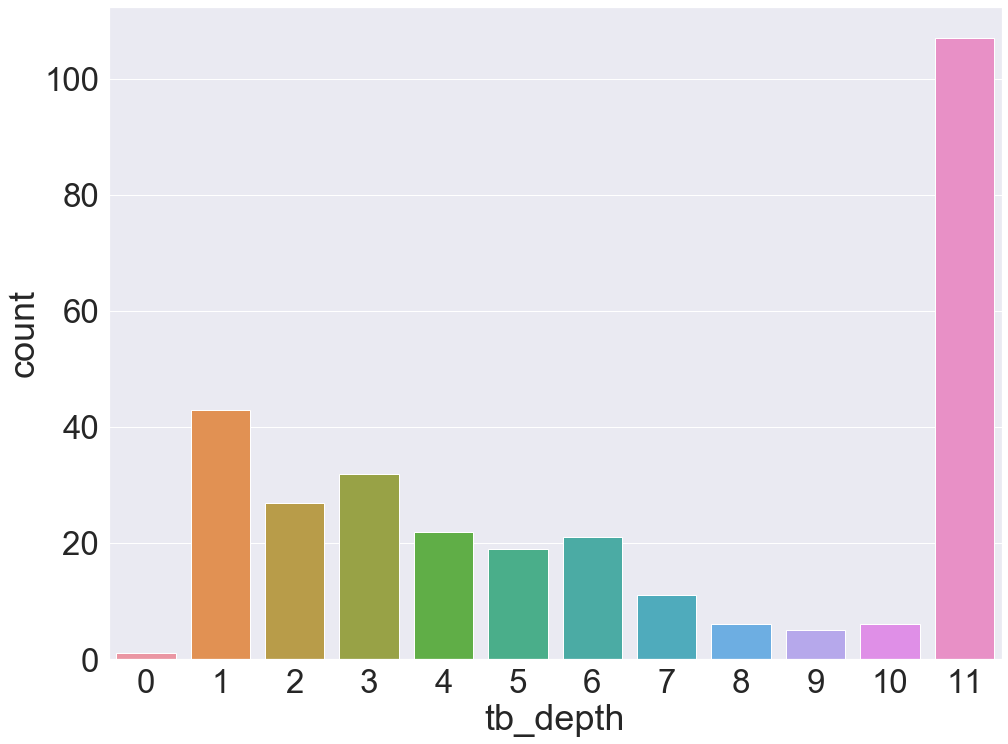

In [12]:
path_to_file = 'dl_chembl/aae.csv'
df_chembl_aae = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_aae)

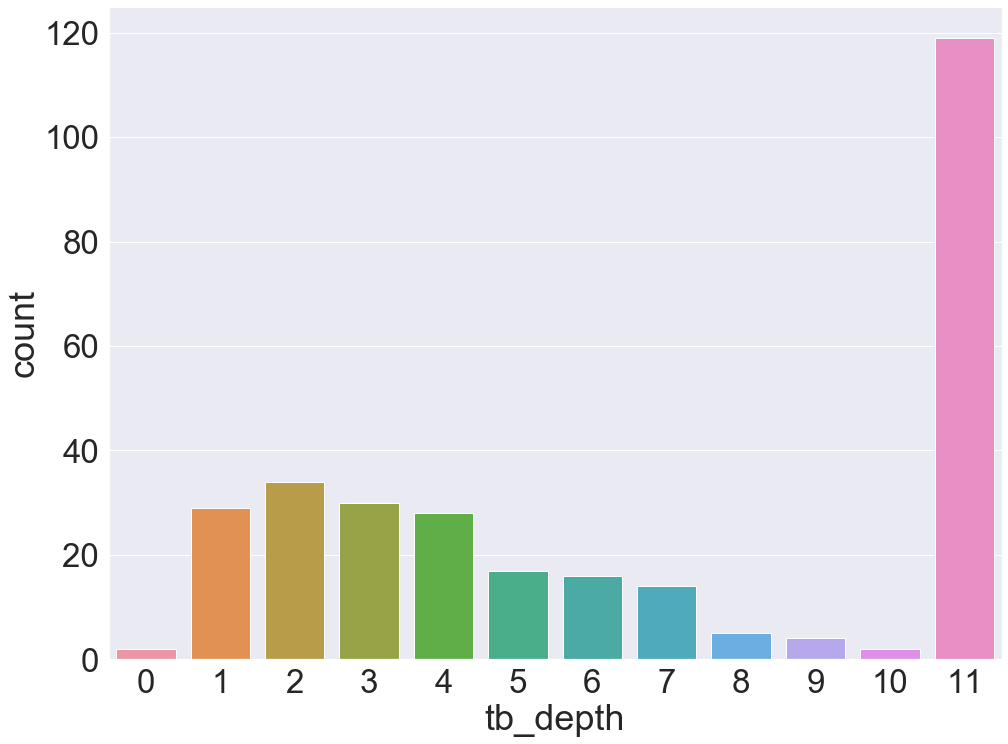

In [13]:
path_to_file = 'dl_chembl/char_rnn.csv'
df_chembl_char_rnn = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_char_rnn)

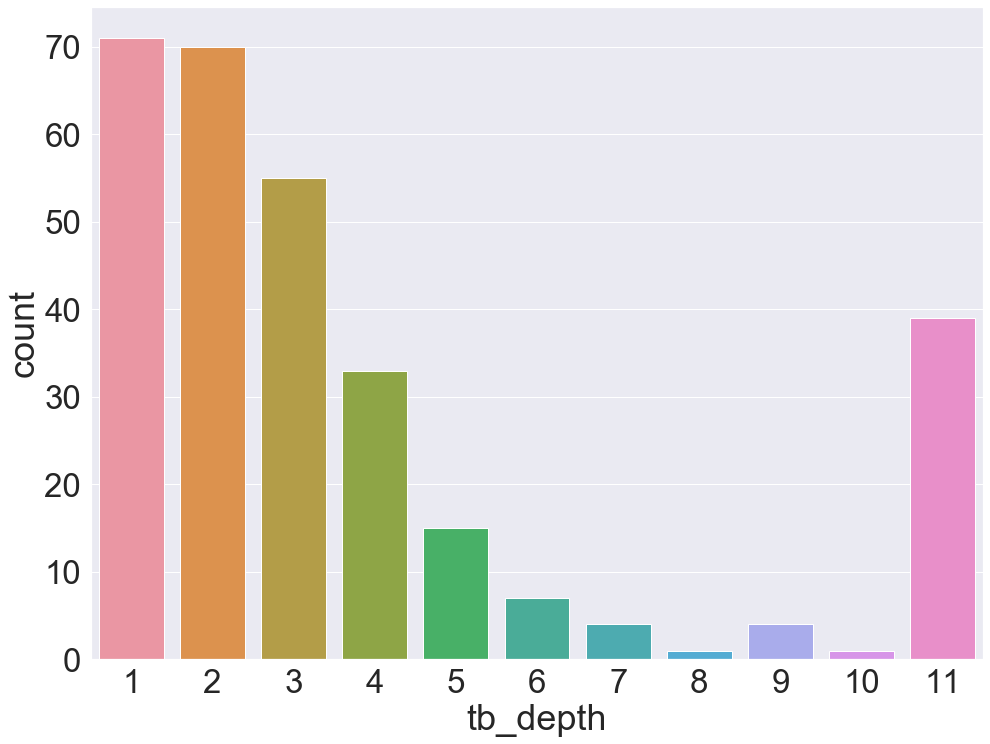

In [14]:
path_to_file = 'dl_moses/vae.csv'
df_moses_vae = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_vae)

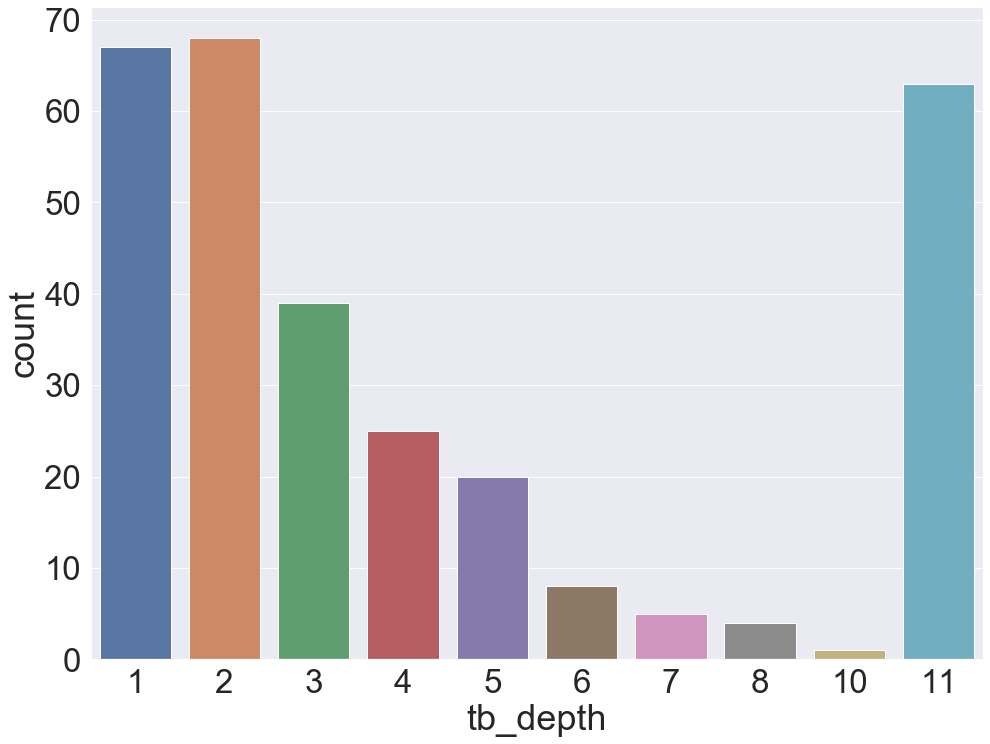

In [15]:
path_to_file = 'dl_moses/aae.csv'
df_moses_aae = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_aae)

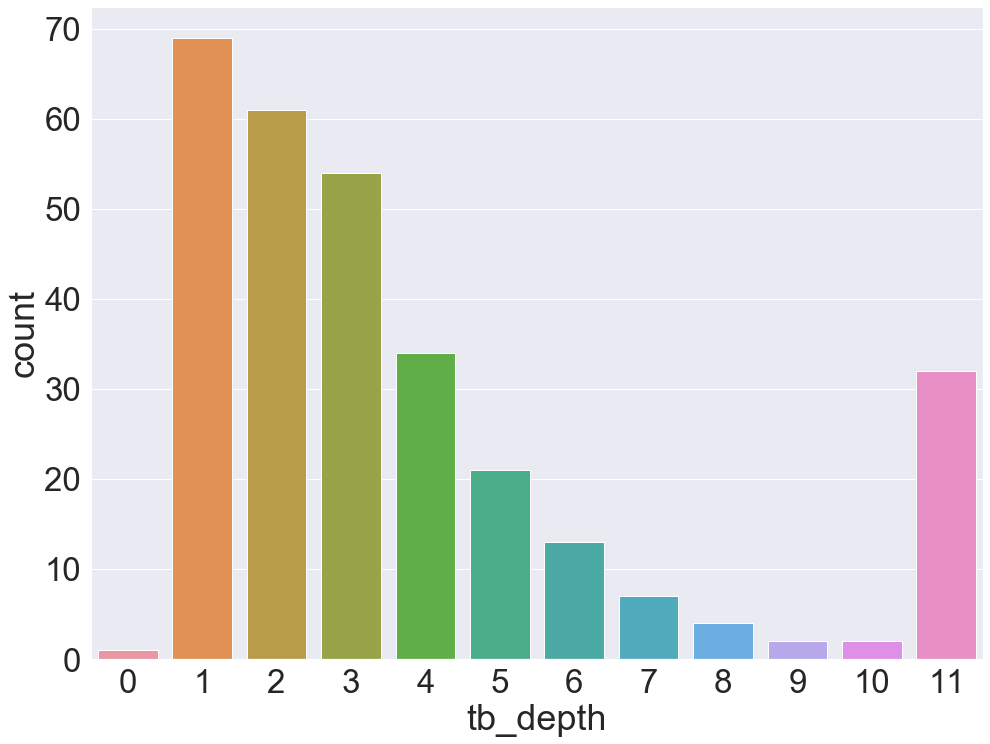

In [16]:
path_to_file = 'dl_moses/char_rnn.csv'
df_moses_char_rnn = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_char_rnn)

In [34]:
df_chembl_vae.to_csv('./dl_chembl_vae.csv', index=False)
df_chembl_aae.to_csv('./dl_chembl_aae.csv', index=False)
df_chembl_char_rnn.to_csv('./dl_chembl_char_rnn.csv', index=False)

In [35]:
df_moses_aae.to_csv('./dl_moses_aae.csv', index=False)
df_moses_vae.to_csv('./dl_moses_vae.csv', index=False)
df_moses_char_rnn.to_csv('./dl_moses_char_rnn.csv', index=False)

In [17]:
df_moses_aae['dataset'] = 'moses'
df_moses_aae['method'] = 'aae'

df_moses_vae['dataset'] = 'moses'
df_moses_vae['method'] = 'vae'

df_moses_char_rnn['dataset'] = 'moses'
df_moses_char_rnn['method'] = 'char_rnn'

df_chembl_vae['dataset'] = 'chembl'
df_chembl_vae['method'] = 'vae'

df_chembl_aae['dataset'] = 'chembl'
df_chembl_aae['method'] = 'aae'

df_chembl_char_rnn['dataset'] = 'chembl'
df_chembl_char_rnn['method'] = 'char_rnn'

In [18]:
df_dl = pd.concat([df_moses_aae, df_moses_vae, df_moses_char_rnn, df_chembl_vae, df_chembl_aae, df_chembl_char_rnn])
df_dl

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,len_smiles,dataset,method
0,O=C(CS(=O)(=O)c1cccs1)NC1CCc2ccccc21,1,3,0.966991,8.0,36,moses,aae
1,Nc1c(C(=O)NCC(F)(F)F)nnn1-c1ccc(Cl)cc1,0,11,0.000000,-1.0,38,moses,aae
2,CCS(=O)(=O)N(C)C(C)c1ccccc1OC(F)F,1,3,0.230302,85.0,33,moses,aae
3,COC(=O)C(C)(C)NC(=O)c1sccc1OC,1,2,0.578832,13.0,29,moses,aae
4,COC(=O)c1[nH]c(C)cc1NC(=O)c1cnn(Cc2ccccc2)c1C,1,3,0.152077,78.0,45,moses,aae
...,...,...,...,...,...,...,...,...
295,Cn1c(=O)[nH]c(=O)c2nnc(S)nc21,0,11,0.000000,-1.0,29,chembl,char_rnn
296,COc1cc(C=C2Cc3c(O)ccc(O)c3C(=O)C2=O)ccc1O,1,7,0.351264,22.0,41,chembl,char_rnn
297,COC(=O)c1c(C)[nH]c(C)c1C(=O)COc1cc(C)ccc1C,1,2,0.360997,37.0,42,chembl,char_rnn
298,CC1(C)CC(=O)C2=C(C1)N(c1ccc(C(=O)O)cc1)C(=O)C2=O,0,11,0.000000,-1.0,48,chembl,char_rnn


In [19]:
df_dl.to_csv('./dl.csv', index=False)

# Goal directed generation

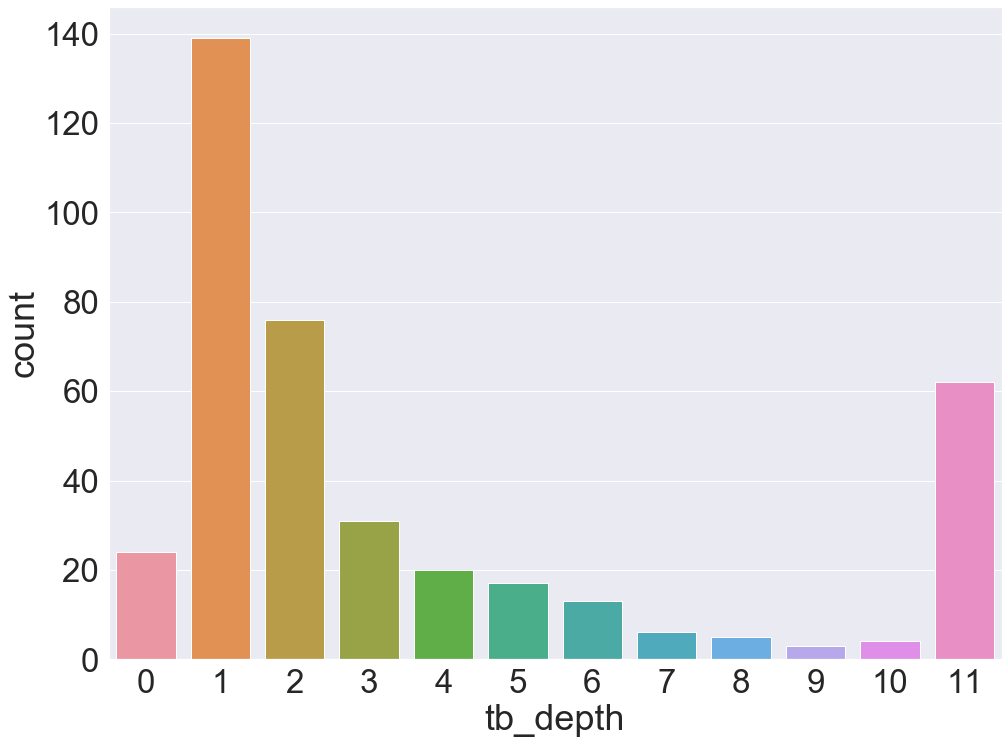

In [21]:
path_to_file = 'goal_trivial/moses_wo/best_from_chembl.csv'
df_moses_wo_vs = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wo_vs)

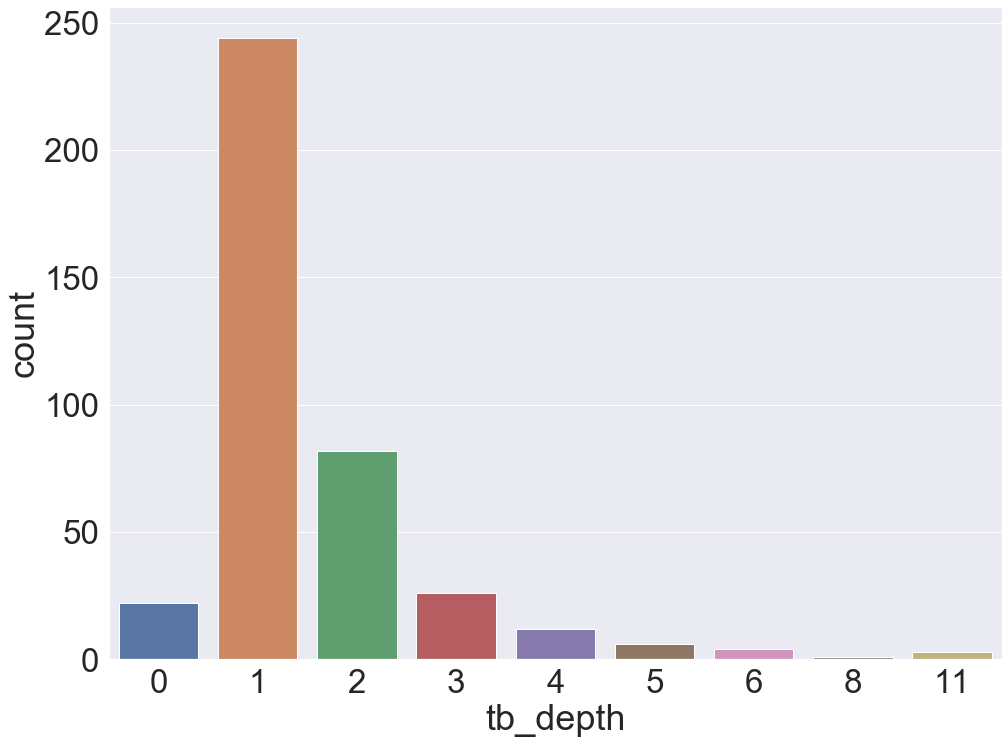

In [22]:
path_to_file = 'goal_trivial/moses_wa/best_from_chembl.csv'
df_moses_wa_vs = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wa_vs)

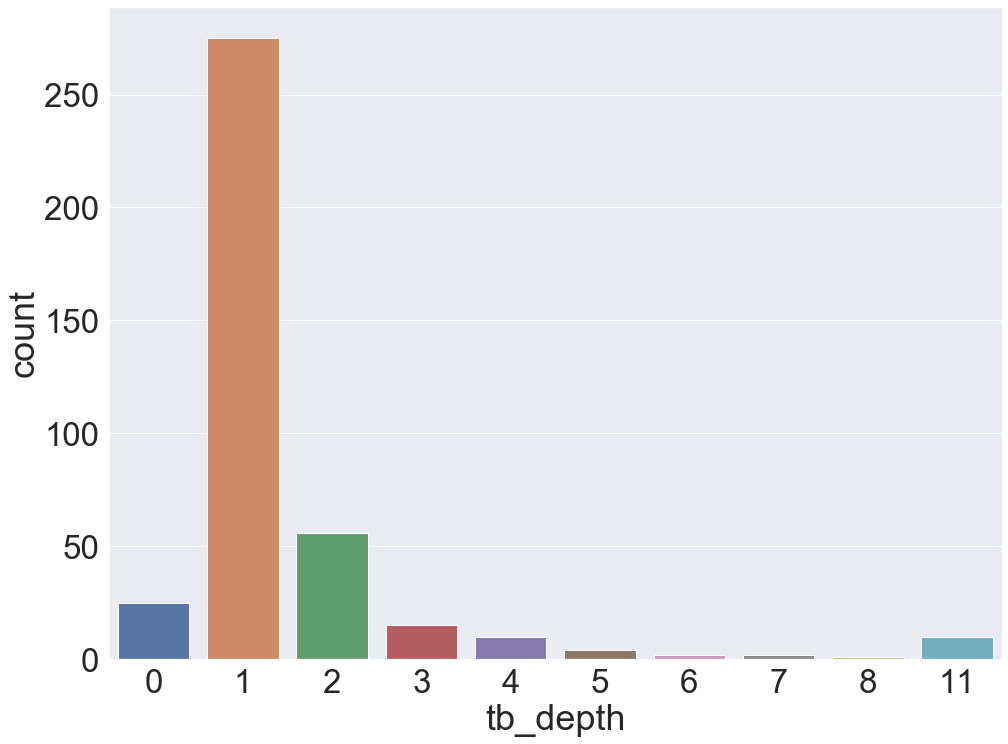

In [23]:
path_to_file = 'goal_trivial/moses_wc/best_from_chembl.csv'
df_moses_wc_vs = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wc_vs)

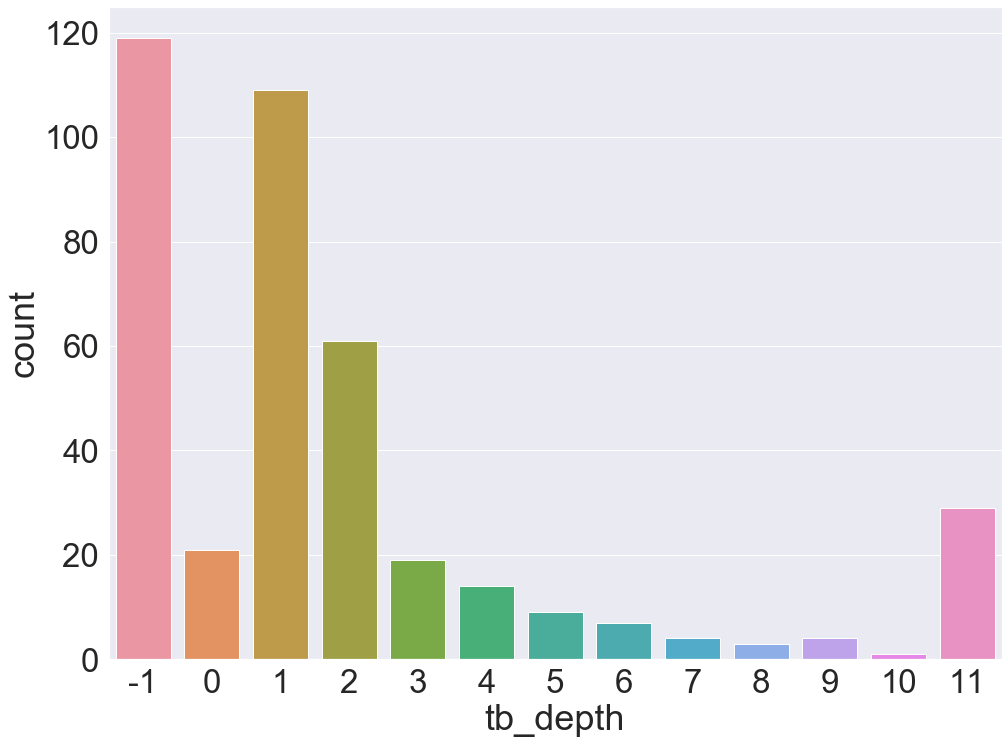

In [24]:
path_to_file = 'goal_trivial/moses_wo/smiles_ga.csv'
df_moses_wo_sga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wo_sga)

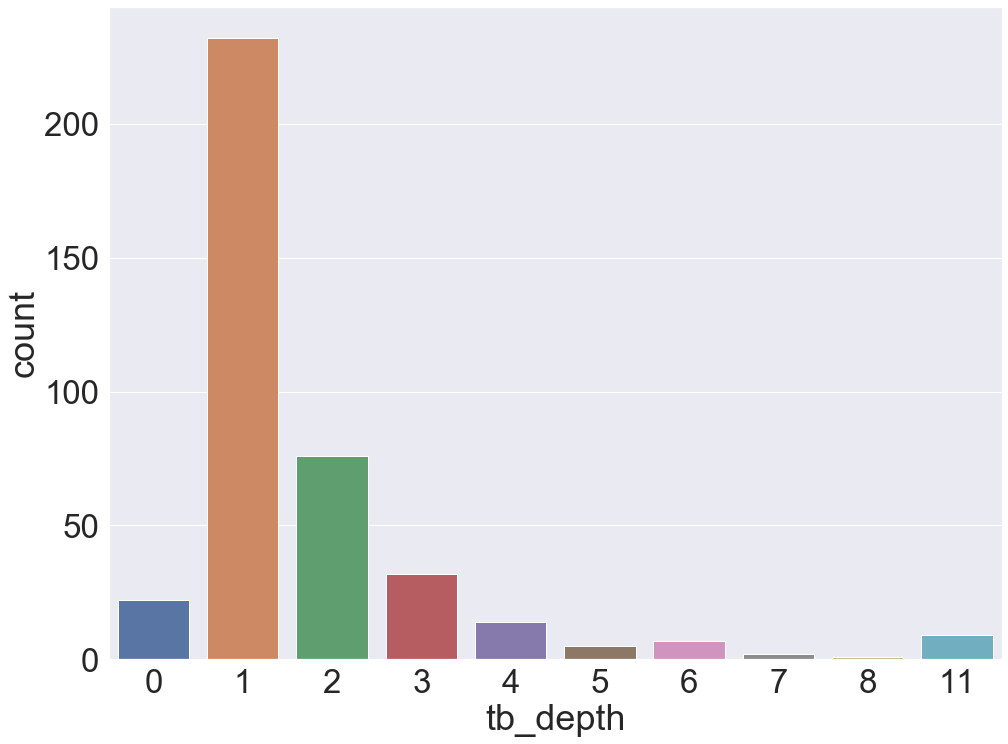

In [25]:
path_to_file = 'goal_trivial/moses_wa/smiles_ga.csv'
df_moses_wa_sga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wa_sga)

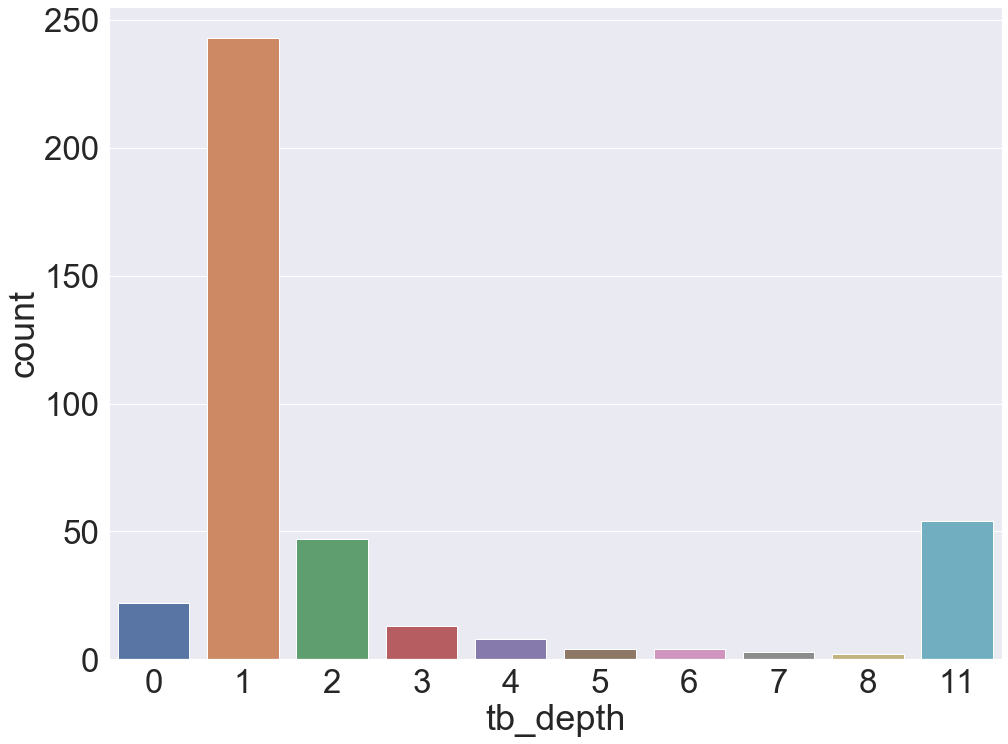

In [26]:
path_to_file = 'goal_trivial/moses_wc/smiles_ga.csv'
df_moses_wc_sga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wc_sga)

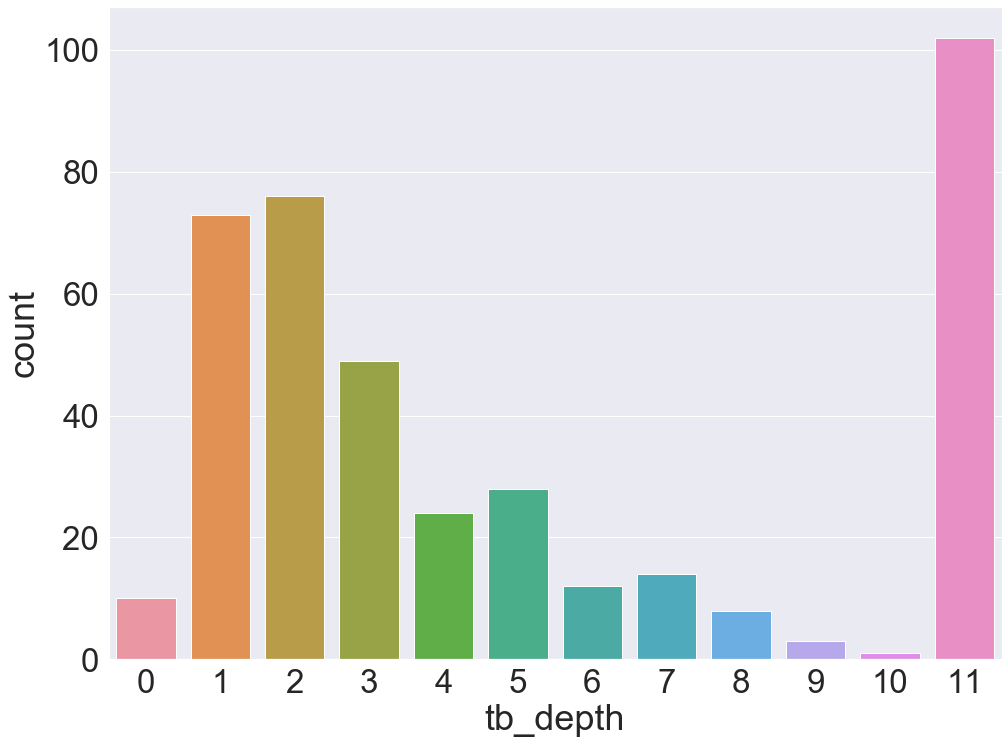

In [27]:
path_to_file = 'goal_trivial/moses_wo/smiles_lstm.csv'
df_moses_wo_slstm = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wo_slstm)

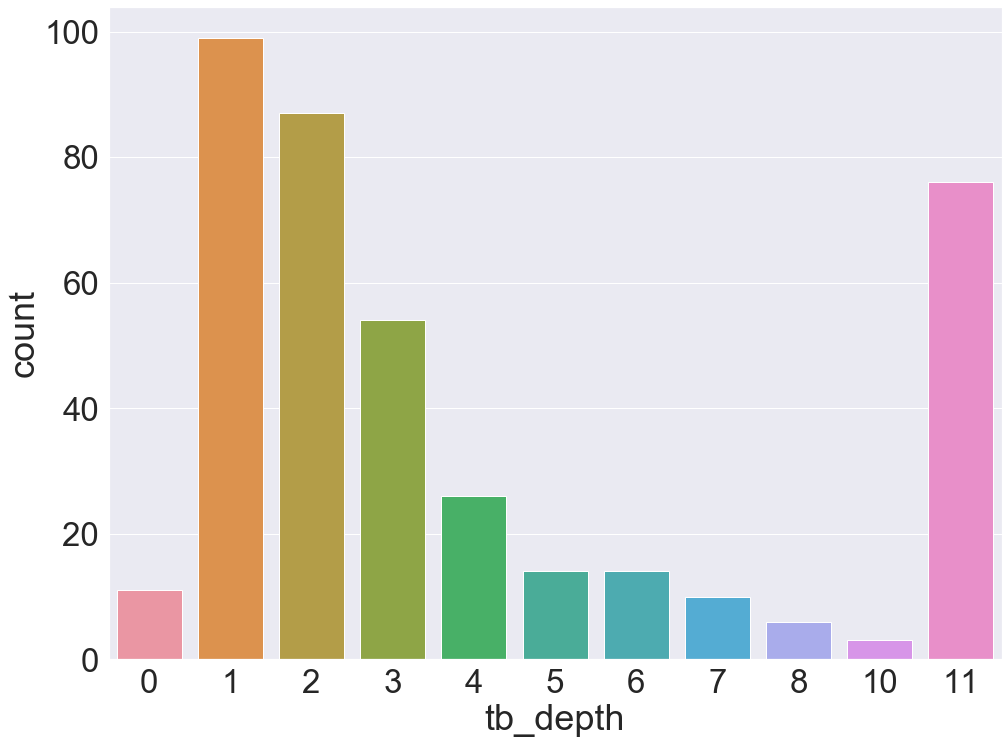

In [28]:
path_to_file = 'goal_trivial/moses_wa/smiles_lstm.csv'
df_moses_wa_slstm = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wa_slstm)

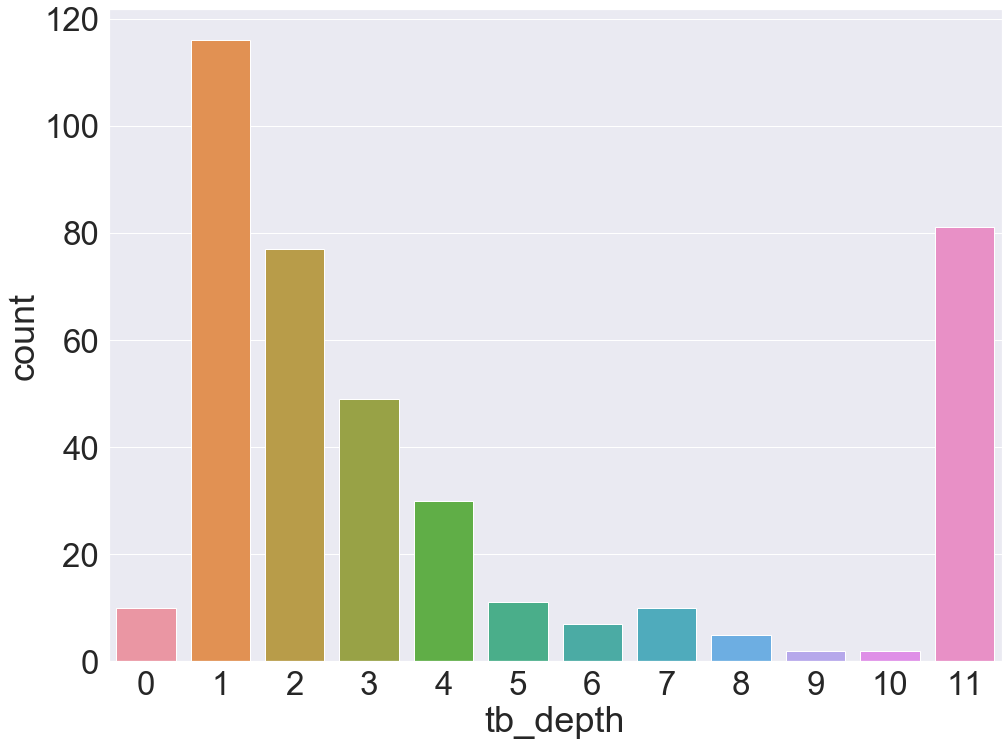

In [29]:
path_to_file = 'goal_trivial/moses_wc/smiles_lstm.csv'
df_moses_wc_slstm = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wc_slstm)

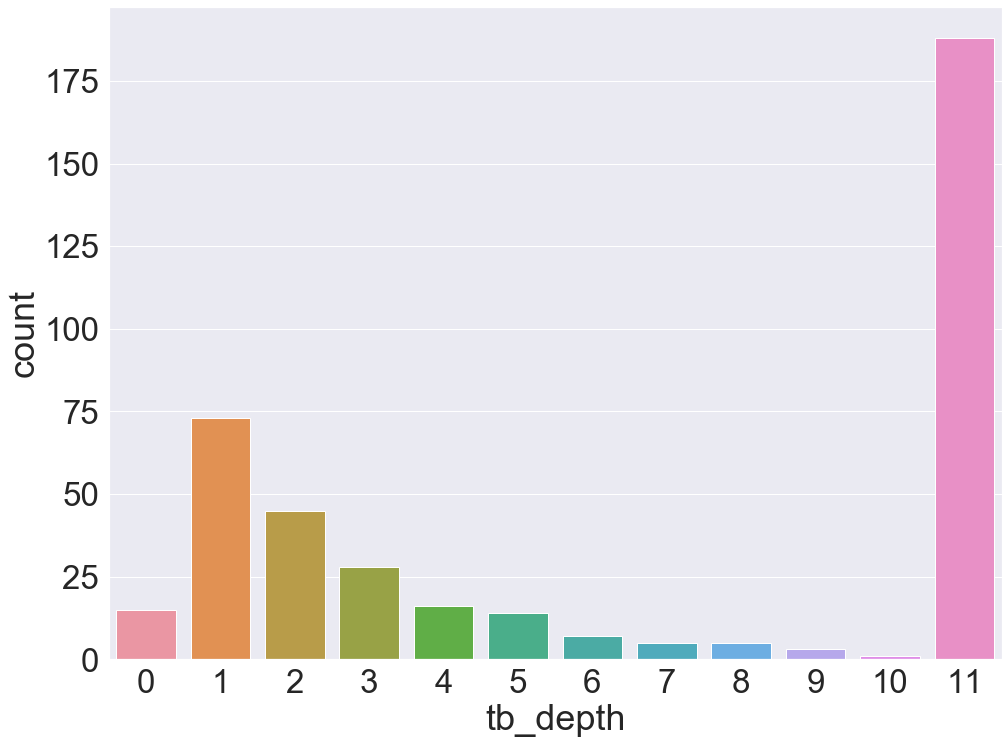

In [30]:
path_to_file = 'goal_trivial/moses_wo/graph_ga.csv'
df_moses_wo_gga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wo_gga)

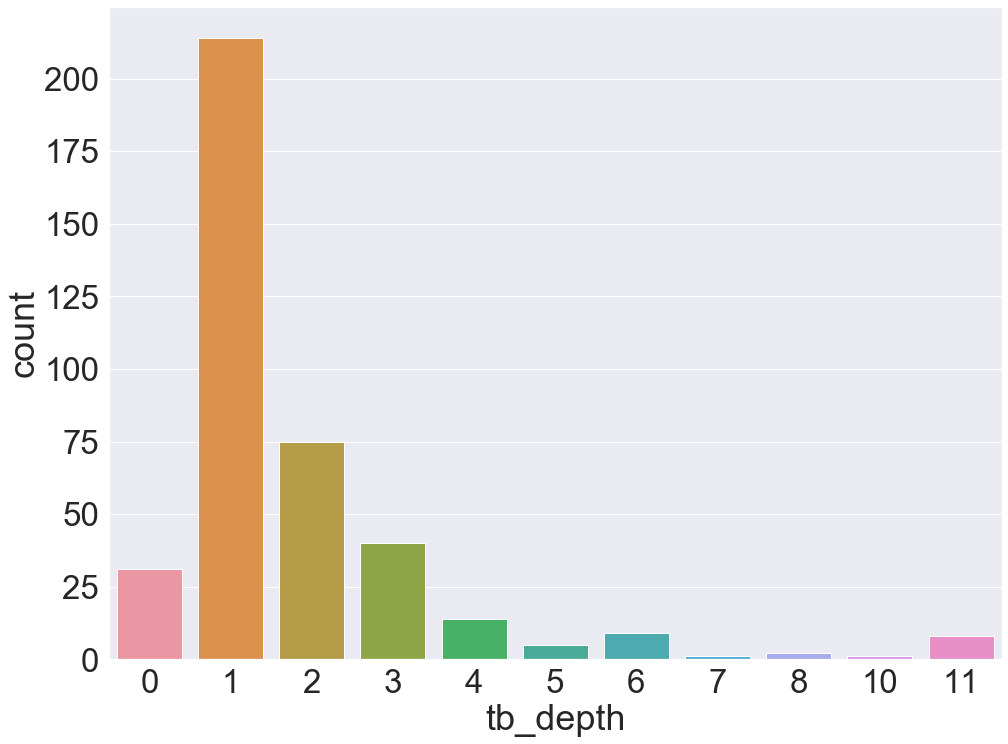

In [31]:
path_to_file = 'goal_trivial/moses_wa/graph_ga.csv'
df_moses_wa_gga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wa_gga)

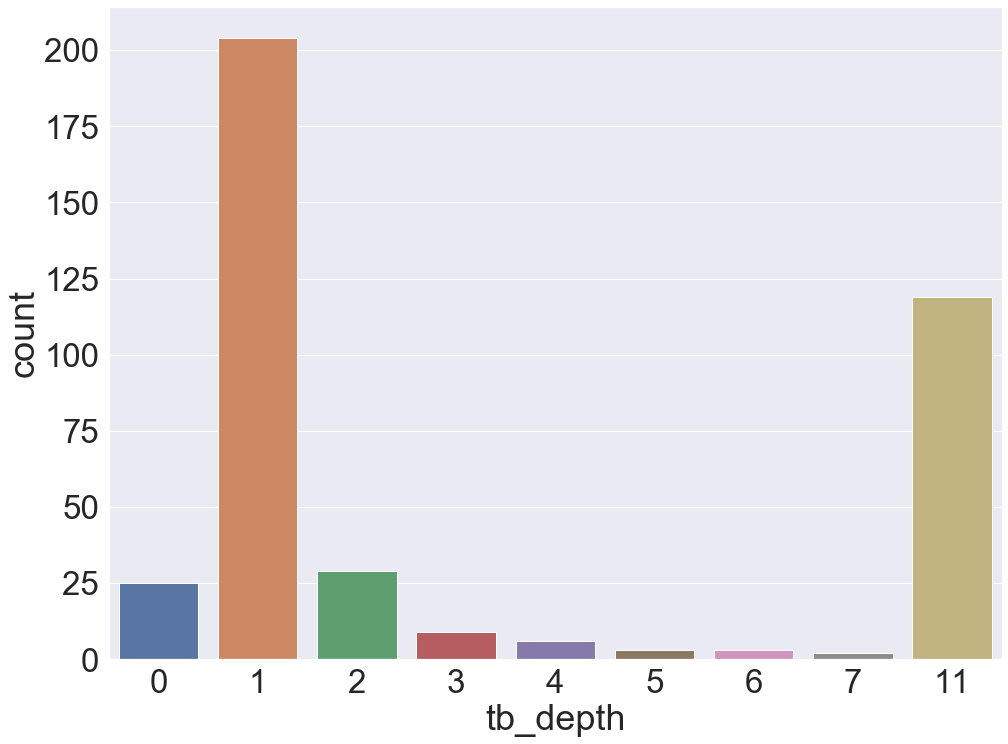

In [32]:
path_to_file = 'goal_trivial/moses_wc/graph_ga.csv'
df_moses_wc_gga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wc_gga)

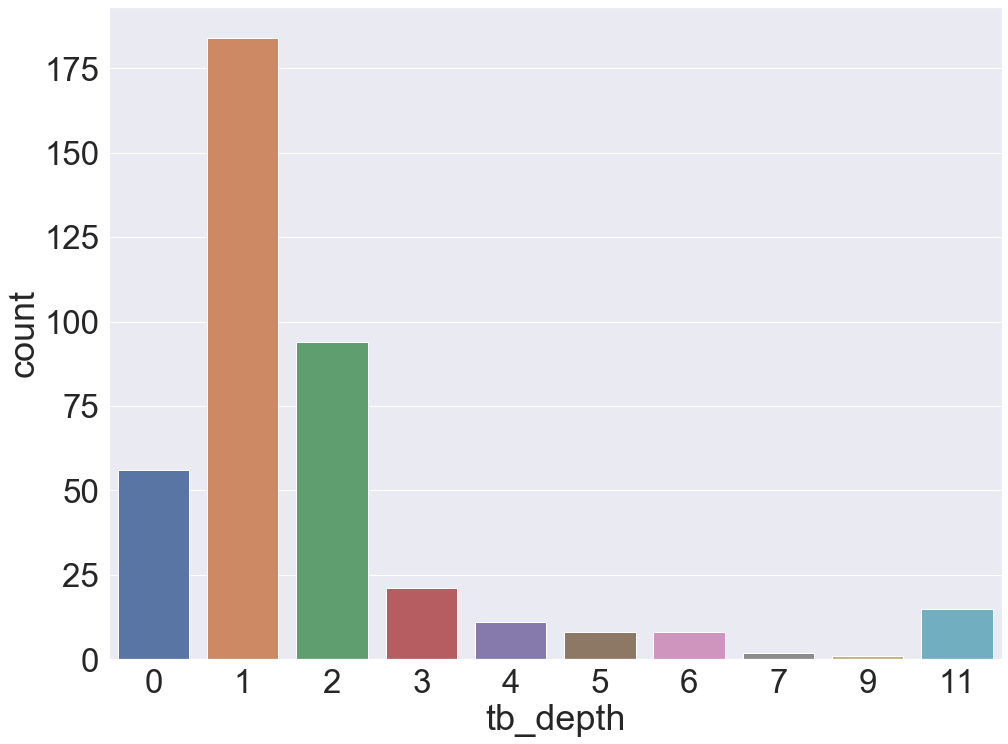

In [33]:
path_to_file = 'goal_trivial/chembl_wa/best_from_chembl.csv'
df_chembl_wa_vs = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_wa_vs)

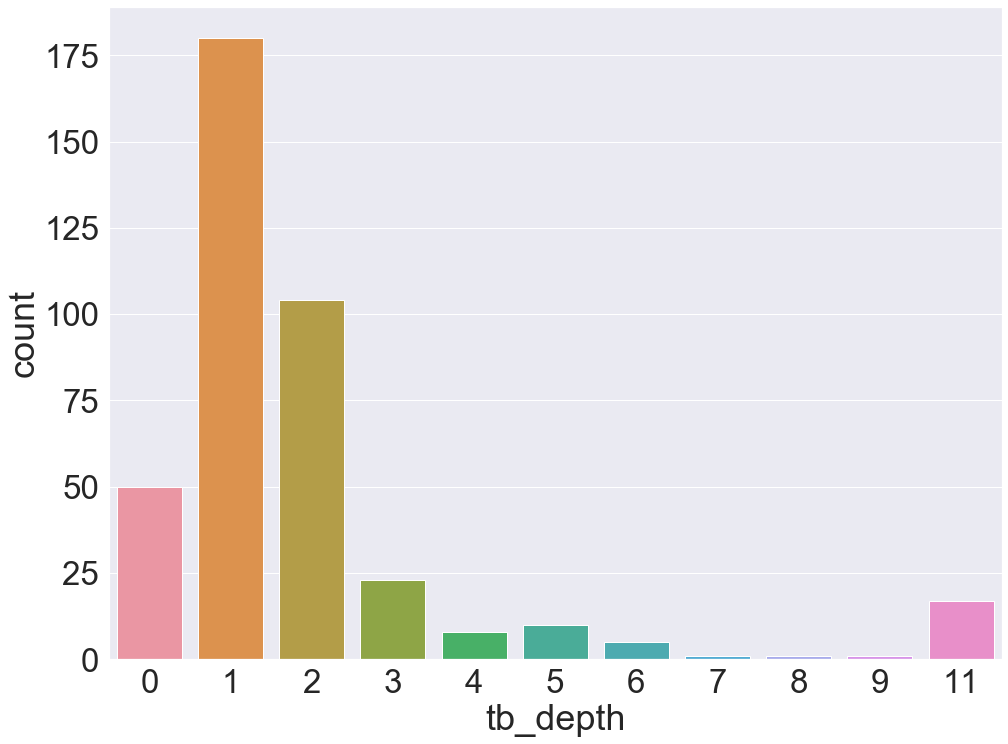

In [34]:
path_to_file = 'goal_trivial/chembl_wa/smiles_ga.csv'
df_chembl_wa_sga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_wa_sga)

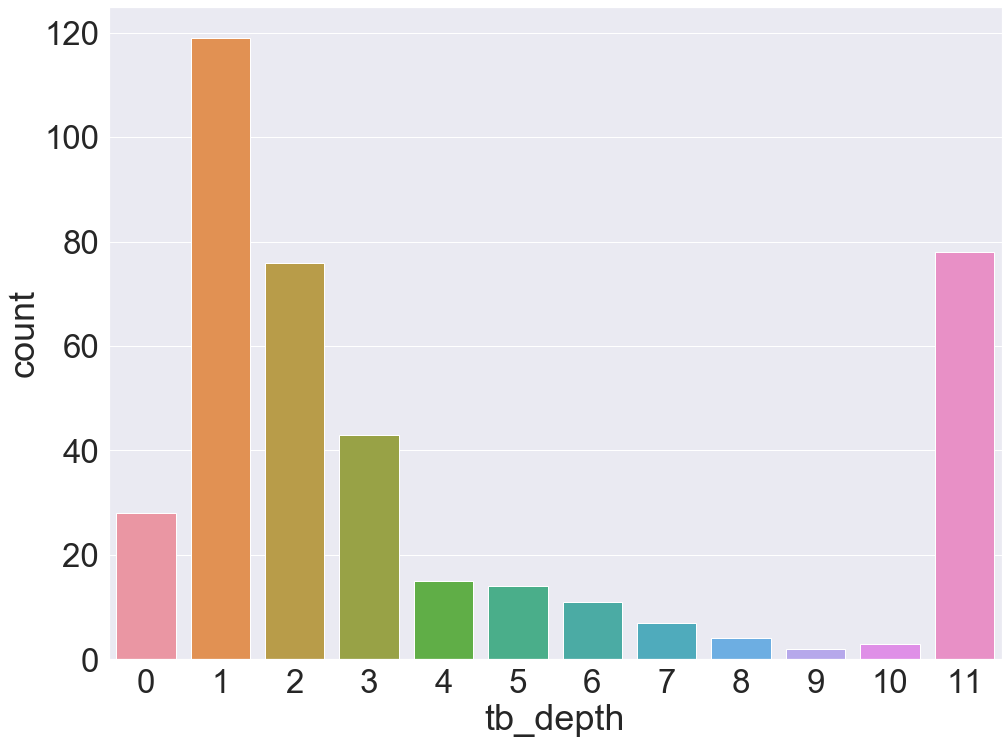

In [35]:
path_to_file = 'goal_trivial/chembl_wa/smiles_lstm.csv'
df_chembl_wa_slstm = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_wa_slstm)

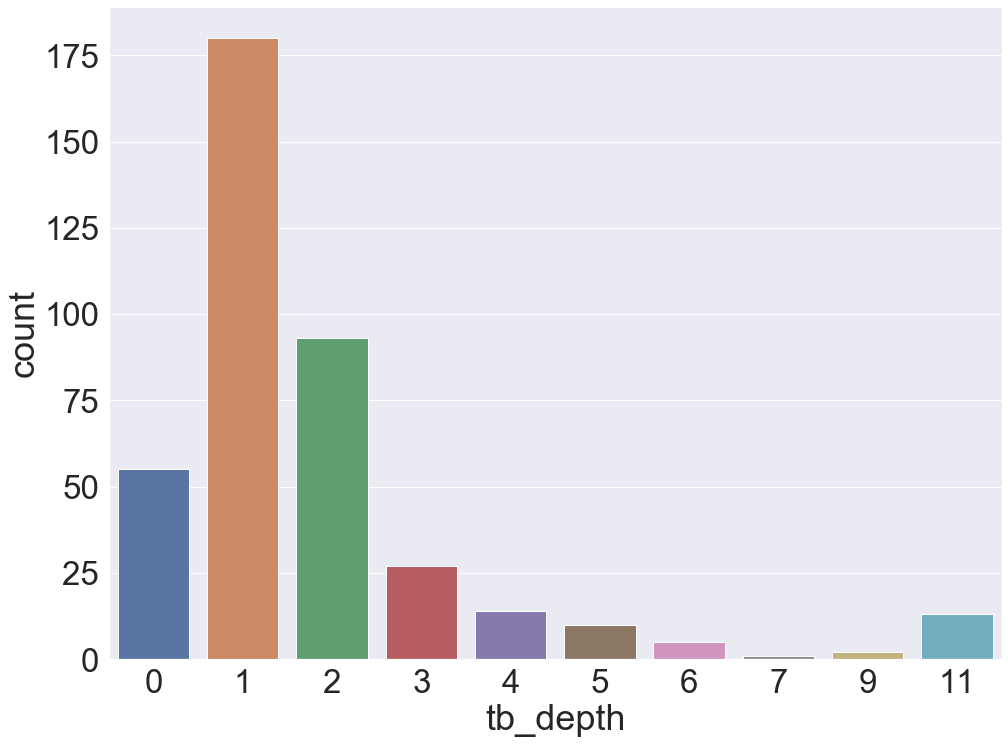

In [36]:
path_to_file = 'goal_trivial/chembl_wa/graph_ga.csv'
df_chembl_wa_gga = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_wa_gga)

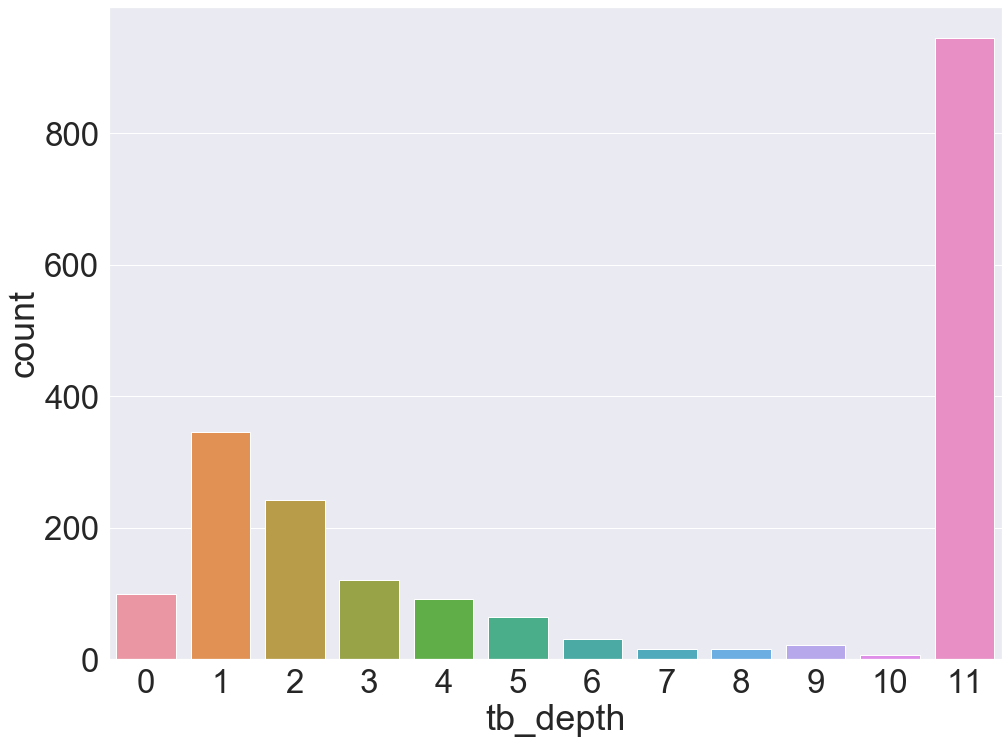

In [37]:
path_to_file = 'goal_trivial/chembl_wo/guacamol_trivial.csv'
df_chembl_wo = process_data(path_to_file)
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_wo)

In [185]:
len(df_chembl_wo), len(df_chembl_wo[df_chembl_wo['tb_depth'] == 11])

(2000, 945)

In [182]:
df_moses_wa = pd.concat([df_moses_wa_vs, df_moses_wa_sga, df_moses_wa_slstm, df_moses_wa_gga])
df_moses_wa

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,len_smiles
0,O=S(=O)(c1ccccc1)N(Cc1ccccc1)c1ccccn1,1,1,0.999967,2.0,37
1,O=C1CCCN1S(=O)(=O)c1ccc(Cl)cc1,1,1,0.936473,85.0,30
2,O=C(c1ccccn1)N1CCN(C(=O)c2ccccn2)CC1,1,2,0.990199,21.0,36
3,O=C(c1cccc(C(=O)N2CCCC2)c1)N1CCCC1,1,1,0.999951,3.0,34
4,O=C(c1ccc2c(c1)OCO2)N(Cc1ccccc1)c1ccccn1,1,1,0.999932,26.0,40
...,...,...,...,...,...,...
395,Cc1ccc(F)cc1NC(=O)N1CCC(C(=O)N2CCOCC2)CC1,-1,-1,-1.000000,-1.0,41
396,Cc1cc(F)ccc1NC(=O)N1CCC(C(=O)N2CCOCC2)CC1,-1,-1,-1.000000,-1.0,41
397,COC(=O)N1CCCN(C(=O)c2ccc(N3CCCC3)c(F)c2)CC1,-1,-1,-1.000000,-1.0,43
398,Cc1cc(NC(=O)N2CCC(C(=O)N3CCOCC3)CC2)ccc1F,-1,-1,-1.000000,-1.0,41


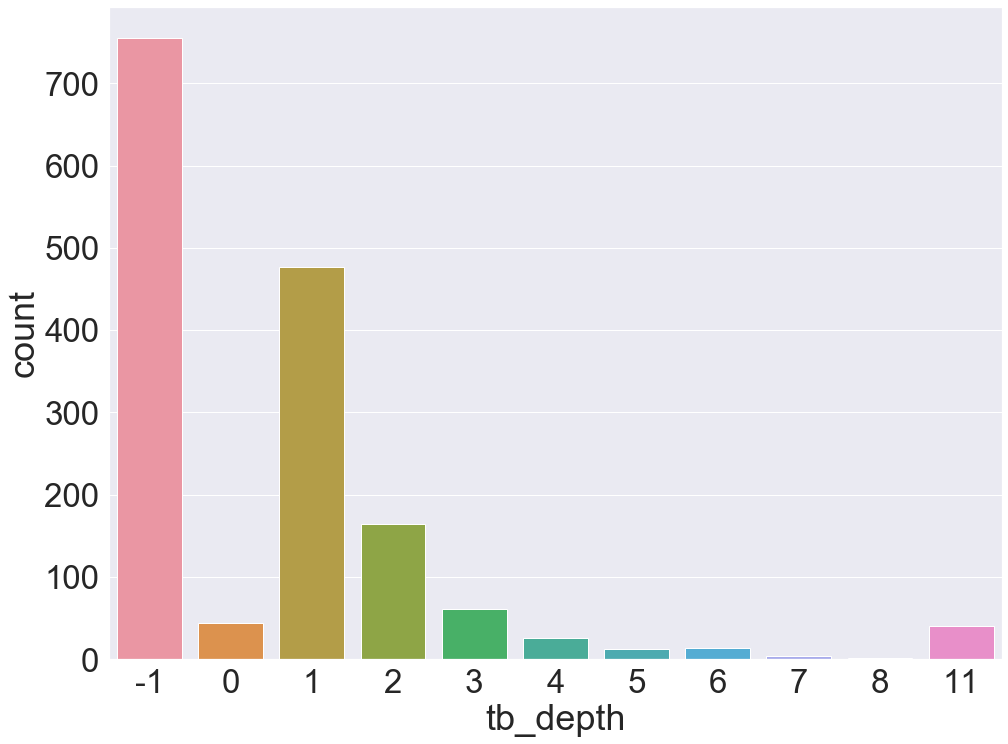

In [183]:
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_moses_wa)

In [186]:
df_chembl_wa = pd.concat([df_chembl_wa_vs, df_chembl_wa_sga, df_chembl_wa_slstm, df_chembl_wa_gga])
df_chembl_wa

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,len_smiles
0,c1ccc2c(c1)nc(CN1CCOCC1)n1c3ccccc3nc21,1,4,0.899353,79.0,38
1,c1ccc(-c2nnc(-c3ccccn3)nc2-c2ccccc2)cc1,1,0,1.000000,21.0,39
2,c1ccc(-c2nc(Cn3cncn3)no2)cc1,1,1,1.000000,101.0,28
3,O=c1cc(Cn2ccnc2)c2ccc(OCc3ccccc3)cc2o1,1,2,0.932990,82.0,38
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,1,4,0.655975,14.0,43
...,...,...,...,...,...,...
395,Brc1ccc(C2CCN(C3CCCCCCC3)CC2)cc1,1,1,0.999874,56.0,32
396,O=C(N1CCCCCC1)N1CC(c2nc(-c3cccc(Cl)c3)no2)C1,1,4,0.999138,51.0,44
397,Cc1ccc(N2CCC(C3CCN(C(=O)OC(C)(C)C)CC3)CC2)cc1,1,1,0.999564,94.0,45
398,N#Cc1c(NC(=S)NC(=O)c2ccccc2)sc2c1CCCCC2,1,1,1.000000,80.0,39


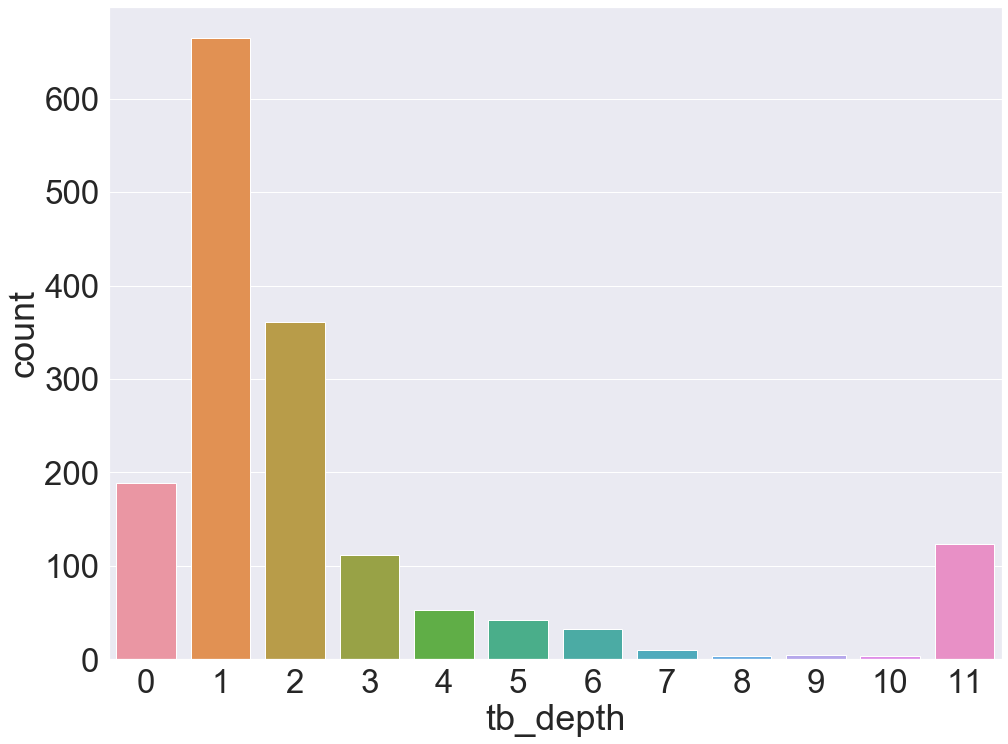

In [187]:
fig = plt.figure(figsize=[16, 12])
sns.set(font_scale=3)
ax = sns.countplot(x='tb_depth', data=df_chembl_wa)

In [218]:
df_moses_wo_vs['dataset'] = 'moses'
df_moses_wo_vs['type'] = 'wo'
df_moses_wo_vs['method'] = 'best_from_chembl'

df_moses_wo_slstm['dataset'] = 'moses'
df_moses_wo_slstm['type'] = 'wo'
df_moses_wo_slstm['method'] = 'smiles_lstm'

df_moses_wo_sga['dataset'] = 'moses'
df_moses_wo_sga['type'] = 'wo'
df_moses_wo_sga['method'] = 'smiles_ga'

df_moses_wo_gga['dataset'] = 'moses'
df_moses_wo_gga['type'] = 'wo'
df_moses_wo_gga['method'] = 'graph_ga'



df_moses_wa_vs['dataset'] = 'moses'
df_moses_wa_vs['type'] = 'wa'
df_moses_wa_vs['method'] = 'best_from_chembl'

df_moses_wa_slstm['dataset'] = 'moses'
df_moses_wa_slstm['type'] = 'wa'
df_moses_wa_slstm['method'] = 'smiles_lstm'

df_moses_wa_sga['dataset'] = 'moses'
df_moses_wa_sga['type'] = 'wa'
df_moses_wa_sga['method'] = 'smiles_ga'

df_moses_wa_gga['dataset'] = 'moses'
df_moses_wa_gga['type'] = 'wa'
df_moses_wa_gga['method'] = 'graph_ga'



df_moses_wc_vs['dataset'] = 'moses'
df_moses_wc_vs['type'] = 'wc'
df_moses_wc_vs['method'] = 'best_from_chembl'

df_moses_wc_slstm['dataset'] = 'moses'
df_moses_wc_slstm['type'] = 'wc'
df_moses_wc_slstm['method'] = 'smiles_lstm'

df_moses_wc_sga['dataset'] = 'moses'
df_moses_wc_sga['type'] = 'wc'
df_moses_wc_sga['method'] = 'smiles_ga'

df_moses_wc_gga['dataset'] = 'moses'
df_moses_wc_gga['type'] = 'wc'
df_moses_wc_gga['method'] = 'graph_ga'

In [219]:
# df_chembl_wo_vs['dataset'] = 'chembl'
# df_chembl_wo_vs['type'] = 'wo'
# df_chembl_wo_vs['method'] = 'best_from_chembl'

# df_chembl_wo_slstm['dataset'] = 'chembl'
# df_chembl_wo_slstm['type'] = 'wo'
# df_chembl_wo_slstm['method'] = 'smiles_lstm'

# df_chembl_wo_sga['dataset'] = 'chembl'
# df_chembl_wo_sga['type'] = 'wo'
# df_chembl_wo_sga['method'] = 'smiles_ga'

# df_chembl_wo_gga['dataset'] = 'chembl'
# df_chembl_wo_gga['type'] = 'wo'
# df_chembl_wo_gga['method'] = 'graph_ga'



df_chembl_wa_vs['dataset'] = 'chembl'
df_chembl_wa_vs['type'] = 'wa'
df_chembl_wa_vs['method'] = 'best_from_chembl'

df_chembl_wa_slstm['dataset'] = 'chembl'
df_chembl_wa_slstm['type'] = 'wa'
df_chembl_wa_slstm['method'] = 'smiles_lstm'

df_chembl_wa_sga['dataset'] = 'chembl'
df_chembl_wa_sga['type'] = 'wa'
df_chembl_wa_sga['method'] = 'smiles_ga'

df_chembl_wa_gga['dataset'] = 'chembl'
df_chembl_wa_gga['type'] = 'wa'
df_chembl_wa_gga['method'] = 'graph_ga'



df_chembl_wc_vs['dataset'] = 'chembl'
df_chembl_wc_vs['type'] = 'wc'
df_chembl_wc_vs['method'] = 'best_from_chembl'

df_chembl_wc_slstm['dataset'] = 'chembl'
df_chembl_wc_slstm['type'] = 'wc'
df_chembl_wc_slstm['method'] = 'smiles_lstm'

df_chembl_wc_sga['dataset'] = 'chembl'
df_chembl_wc_sga['type'] = 'wc'
df_chembl_wc_sga['method'] = 'smiles_ga'

df_chembl_wc_gga['dataset'] = 'chembl'
df_chembl_wc_gga['type'] = 'wc'
df_chembl_wc_gga['method'] = 'graph_ga'

In [201]:
df_goal = pd.concat([df_moses_wo_vs, df_moses_wo_slstm, df_moses_wo_sga, df_moses_wo_gga])

In [206]:
df_chembl_wo

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,len_smiles
0,c1ccc2c(c1)COc1c3cc4c(cc3nn1-2)OCO4,0,11,0.000000,-1.0,35
1,c1ccc(Cc2nc(CN3CCCC3Cn3cncn3)cs2)cc1,1,5,0.720217,73.0,36
2,O=c1nc(Oc2ccccc2)nc2ncccn12,0,11,0.000000,-1.0,27
3,O=c1cc(N2CCOCC2)oc2c(-c3ccoc3)csc12,0,11,0.000000,-1.0,35
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,1,4,0.655975,14.0,43
...,...,...,...,...,...,...
1995,CC1(C)CC(C(=O)N2CCC3(CC2)CCN(S(C)(=O)=O)CC3)CO1,1,9,0.908122,90.0,47
1996,CC1OC(CN(C)C)C(=N)OC(Cl)C(N)C(Br)C1N,0,11,0.000000,-1.0,36
1997,O=C(CC1CCCCCC1)N1CCC2(CC1)OOC1(CCCC1)OO2,1,4,0.835307,108.0,40
1998,O=C(N1CCCC(C(=O)O)(C(F)(F)F)C1)C12CC3CC(CC(C3)...,0,11,0.000000,-1.0,51


In [207]:
df_guacamol_orig = pd.read_csv('./goal/chembl_wo/guacamol_trivial.csv')
df_guacamol_orig

,SMILES,source,property
0,c1ccc2c(c1)COc1c3cc4c(cc3nn1-2)OCO4,virtual_screening,CNS MPO
1,c1ccc(Cc2nc(CN3CCCC3Cn3cncn3)cs2)cc1,virtual_screening,CNS MPO
2,O=c1nc(Oc2ccccc2)nc2ncccn12,virtual_screening,CNS MPO
3,O=c1cc(N2CCOCC2)oc2c(-c3ccoc3)csc12,virtual_screening,CNS MPO
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,virtual_screening,CNS MPO
...,...,...,...
1995,CC1(C)CC(C(=O)N2CCC3(CC2)CCN(S(C)(=O)=O)CC3)CO1,smiles_lstm,Pioglitazone MPO
1996,CC1OC(CN(C)C)C(=N)OC(Cl)C(N)C(Br)C1N,smiles_lstm,Pioglitazone MPO
1997,O=C(CC1CCCCCC1)N1CCC2(CC1)OOC1(CCCC1)OO2,smiles_lstm,Pioglitazone MPO
1998,O=C(N1CCCC(C(=O)O)(C(F)(F)F)C1)C12CC3CC(CC(C3)...,smiles_lstm,Pioglitazone MPO


In [208]:
df_chembl_wa_vs

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,len_smiles,dataset,type,method
0,c1ccc2c(c1)nc(CN1CCOCC1)n1c3ccccc3nc21,1,4,0.899353,79.0,38,chembl,wa,best_from_chembl
1,c1ccc(-c2nnc(-c3ccccn3)nc2-c2ccccc2)cc1,1,0,1.000000,21.0,39,chembl,wa,best_from_chembl
2,c1ccc(-c2nc(Cn3cncn3)no2)cc1,1,1,1.000000,101.0,28,chembl,wa,best_from_chembl
3,O=c1cc(Cn2ccnc2)c2ccc(OCc3ccccc3)cc2o1,1,2,0.932990,82.0,38,chembl,wa,best_from_chembl
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,1,4,0.655975,14.0,43,chembl,wa,best_from_chembl
...,...,...,...,...,...,...,...,...,...
395,O=C(N1CCCCC1)N1CCC(c2nc(-c3ccc(F)cc3)no2)CC1,1,3,0.999359,22.0,44,chembl,wa,best_from_chembl
396,Cc1ccc(NC(=O)N2CCOCC2)cc1NC(=O)N1CCOCC1,1,1,0.999989,3.0,39,chembl,wa,best_from_chembl
397,Cc1ccc(S(=O)(=O)N2CCCN(C(=O)OC(C)(C)C)CC2)cc1,1,1,0.999876,14.0,45,chembl,wa,best_from_chembl
398,CC1CCN(S(=O)(=O)c2ccc(Cl)cc2Br)CC1,1,1,0.999840,2.0,34,chembl,wa,best_from_chembl


In [209]:
pd.read_csv('./goal/chembl_wa/best_from_chembl.csv')

,SMILES,property,source
0,c1ccc2c(c1)nc(CN1CCOCC1)n1c3ccccc3nc21,SA_CNS,chembl_wa/best_of_chembl
1,c1ccc(-c2nnc(-c3ccccn3)nc2-c2ccccc2)cc1,SA_CNS,chembl_wa/best_of_chembl
2,c1ccc(-c2nc(Cn3cncn3)no2)cc1,SA_CNS,chembl_wa/best_of_chembl
3,O=c1cc(Cn2ccnc2)c2ccc(OCc3ccccc3)cc2o1,SA_CNS,chembl_wa/best_of_chembl
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,SA_CNS,chembl_wa/best_of_chembl
...,...,...,...
395,O=C(N1CCCCC1)N1CCC(c2nc(-c3ccc(F)cc3)no2)CC1,SA_pioglitazone,chembl_wa/best_of_chembl
396,Cc1ccc(NC(=O)N2CCOCC2)cc1NC(=O)N1CCOCC1,SA_pioglitazone,chembl_wa/best_of_chembl
397,Cc1ccc(S(=O)(=O)N2CCCN(C(=O)OC(C)(C)C)CC2)cc1,SA_pioglitazone,chembl_wa/best_of_chembl
398,CC1CCN(S(=O)(=O)c2ccc(Cl)cc2Br)CC1,SA_pioglitazone,chembl_wa/best_of_chembl


In [40]:
def process_data_goal(csv_file):
    results = []
    name = csv_file.split('.')[0]
    df_file = pd.read_csv(csv_file)
    num = len(df_file)
    for i in range(num):
        json_file = name + '_' + str(i) + '.json'
        if os.path.exists(json_file):
            with open(json_file) as f:
                results.append(json.load(f))

    num_temp = len(results)

    depths = []
    p_scores = []
    synthesizabilitys = []
    smiles = df_file.SMILES
    prices = []
    for i in range(num_temp):
#         smiles.append(results[i]['request']['smiles'][0])
        num_path, status, depth, p_score, synthesizability, price = tree_analysis(results[i])
        depths.append(depth)
        p_scores.append(p_score)
        synthesizabilitys.append(synthesizability)
        prices.append(price)
        
    for i in range(num - num_temp):
        depths.append(-1)
        p_scores.append(-1)
        synthesizabilitys.append(-1)
        prices.append(-1)
    
    df = pd.DataFrame({
        'SMILES': smiles,
        'tb_synthesizability': synthesizabilitys,
        'tb_depth': depths,
        'tb_plausibility': p_scores,
        'tb_price': prices,
        'property': df_file.property
    })
    
    df['len_smiles'] = df.SMILES.apply(len)
    
    return df

In [41]:
path_to_file = 'goal_trivial/moses_wo/best_from_chembl.csv'
df_moses_wo_vs = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wo/smiles_ga.csv'
df_moses_wo_sga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wo/smiles_lstm.csv'
df_moses_wo_slstm = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wo/graph_ga.csv'
df_moses_wo_gga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wa/best_from_chembl.csv'
df_moses_wa_vs = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wa/smiles_ga.csv'
df_moses_wa_sga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wa/smiles_lstm.csv'
df_moses_wa_slstm = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wa/graph_ga.csv'
df_moses_wa_gga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wc/best_from_chembl.csv'
df_moses_wc_vs = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wc/smiles_ga.csv'
df_moses_wc_sga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wc/smiles_lstm.csv'
df_moses_wc_slstm = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/moses_wc/graph_ga.csv'
df_moses_wc_gga = process_data_goal(path_to_file)

# path_to_file = 'goal_trivial/chembl_wo/best_from_chembl.csv'
# df_chembl_wo_vs = process_data_goal(path_to_file)

# path_to_file = 'goal_trivial/chembl_wo/smiles_ga.csv'
# df_chembl_wo_sga = process_data_goal(path_to_file)

# path_to_file = 'goal_trivial/chembl_wo/smiles_lstm.csv'
# df_chembl_wo_slstm = process_data_goal(path_to_file)

# path_to_file = 'goal_trivial/chembl_wo/graph_ga.csv'
# df_chembl_wo_gga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wa/best_from_chembl.csv'
df_chembl_wa_vs = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wa/smiles_ga.csv'
df_chembl_wa_sga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wa/smiles_lstm.csv'
df_chembl_wa_slstm = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wa/graph_ga.csv'
df_chembl_wa_gga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wc/best_from_chembl.csv'
df_chembl_wc_vs = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wc/smiles_ga.csv'
df_chembl_wc_sga = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wc/smiles_lstm.csv'
df_chembl_wc_slstm = process_data_goal(path_to_file)

path_to_file = 'goal_trivial/chembl_wc/graph_ga.csv'
df_chembl_wc_gga = process_data_goal(path_to_file)

In [42]:
df_chembl_wc_gga.head()

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,property,len_smiles
0,O=c1n(CC2CO2)c(=O)n(CC2CO2)n1CC1CO1,0,11,0.000000,-1.0,SC_CNS,35
1,O=c1ccc2ccc(C=NN=Cc3ccc4ccc(=O)oc4c3)cc2o1,1,2,0.424071,12.0,SC_CNS,42
2,O=c1c(-n2cnnc2)coc2ccccc12,1,5,0.006493,14.0,SC_CNS,26
3,O=[N+]([O-])c1ccccc1N=Cc1ccc2c(c1)OCO2,1,1,0.975410,2.0,SC_CNS,38
4,O=[N+]([O-])c1cccc(COc2ccccc2CN2CCCCC2)c1,1,1,0.998606,82.0,SC_CNS,41


In [43]:
df_chembl_wo.head()

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,len_smiles
0,c1ccc2c(c1)COc1c3cc4c(cc3nn1-2)OCO4,0,11,0.000000,-1.0,35
1,c1ccc(Cc2nc(CN3CCCC3Cn3cncn3)cs2)cc1,1,5,0.720217,73.0,36
2,O=c1nc(Oc2ccccc2)nc2ncccn12,0,11,0.000000,-1.0,27
3,O=c1cc(N2CCOCC2)oc2c(-c3ccoc3)csc12,0,11,0.000000,-1.0,35
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,1,4,0.655975,14.0,43


In [225]:
df_chembl_wo['property'] = df_guacamol_orig.property
df_chembl_wo['dataset'] = 'chembl'
df_chembl_wo['type'] = 'wo'
df_chembl_wo['method'] = df_guacamol_orig.source

In [234]:
df_chembl_wa = pd.concat([df_chembl_wa_vs, df_chembl_wa_sga, df_chembl_wa_slstm, df_chembl_wa_gga])
df_chembl_wc = pd.concat([df_chembl_wc_vs, df_chembl_wc_sga, df_chembl_wc_slstm, df_chembl_wc_gga])

In [235]:
df_moses_wo = pd.concat([df_moses_wo_vs, df_moses_wo_sga, df_moses_wo_slstm, df_moses_wo_gga])
df_moses_wa = pd.concat([df_moses_wa_vs, df_moses_wa_sga, df_moses_wa_slstm, df_moses_wa_gga])
df_moses_wc = pd.concat([df_moses_wc_vs, df_moses_wc_sga, df_moses_wc_slstm, df_moses_wc_gga])

In [242]:
for i in range(len(df_chembl_wo)):
    if df_chembl_wo['method'][i] == 'virtual_screening':
        df_chembl_wo['method'][i] = 'best_from_chembl'

/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [246]:
set(df_chembl_wo.method)

{'best_from_chembl', 'graph_ga', 'graph_mcts', 'smiles_ga', 'smiles_lstm'}

In [248]:
df_chembl_wo.to_csv('./chembl_wo.csv', index=False)
df_chembl_wa.to_csv('./chembl_wa.csv', index=False)
df_chembl_wc.to_csv('./chembl_wc.csv', index=False)

df_moses_wo.to_csv('./moses_wo.csv', index=False)
df_moses_wa.to_csv('./moses_wa.csv', index=False)
df_moses_wc.to_csv('./moses_wc.csv', index=False)

In [250]:
df_chembl_wo = df_chembl_wo[df_chembl_wo['method'] != 'graph_mcts']

In [251]:
df_chembl_wo

,SMILES,tb_synthesizability,tb_depth,tb_plausibility,tb_price,len_smiles,property,dataset,type,method
0,c1ccc2c(c1)COc1c3cc4c(cc3nn1-2)OCO4,0,11,0.000000,-1.0,35,CNS MPO,chembl,wo,best_from_chembl
1,c1ccc(Cc2nc(CN3CCCC3Cn3cncn3)cs2)cc1,1,5,0.720217,73.0,36,CNS MPO,chembl,wo,best_from_chembl
2,O=c1nc(Oc2ccccc2)nc2ncccn12,0,11,0.000000,-1.0,27,CNS MPO,chembl,wo,best_from_chembl
3,O=c1cc(N2CCOCC2)oc2c(-c3ccoc3)csc12,0,11,0.000000,-1.0,35,CNS MPO,chembl,wo,best_from_chembl
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,1,4,0.655975,14.0,43,CNS MPO,chembl,wo,best_from_chembl
...,...,...,...,...,...,...,...,...,...,...
1995,CC1(C)CC(C(=O)N2CCC3(CC2)CCN(S(C)(=O)=O)CC3)CO1,1,9,0.908122,90.0,47,Pioglitazone MPO,chembl,wo,smiles_lstm
1996,CC1OC(CN(C)C)C(=N)OC(Cl)C(N)C(Br)C1N,0,11,0.000000,-1.0,36,Pioglitazone MPO,chembl,wo,smiles_lstm
1997,O=C(CC1CCCCCC1)N1CCC2(CC1)OOC1(CCCC1)OO2,1,4,0.835307,108.0,40,Pioglitazone MPO,chembl,wo,smiles_lstm
1998,O=C(N1CCCC(C(=O)O)(C(F)(F)F)C1)C12CC3CC(CC(C3)...,0,11,0.000000,-1.0,51,Pioglitazone MPO,chembl,wo,smiles_lstm


In [252]:
df_goal = pd.concat([df_chembl_wo, df_chembl_wa, df_chembl_wc, df_moses_wo, df_moses_wa, df_moses_wc])

/Users/gaowh/anaconda3/envs/rdkit/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [253]:
df_goal

,SMILES,dataset,len_smiles,method,property,tb_depth,tb_plausibility,tb_price,tb_synthesizability,type
0,c1ccc2c(c1)COc1c3cc4c(cc3nn1-2)OCO4,chembl,35,best_from_chembl,CNS MPO,11,0.000000,-1.0,0,wo
1,c1ccc(Cc2nc(CN3CCCC3Cn3cncn3)cs2)cc1,chembl,36,best_from_chembl,CNS MPO,5,0.720217,73.0,1,wo
2,O=c1nc(Oc2ccccc2)nc2ncccn12,chembl,27,best_from_chembl,CNS MPO,11,0.000000,-1.0,0,wo
3,O=c1cc(N2CCOCC2)oc2c(-c3ccoc3)csc12,chembl,35,best_from_chembl,CNS MPO,11,0.000000,-1.0,0,wo
4,O=c1c2cc3c(cc2ncn1Cc1ccc(-c2ccccc2)cc1)OCO3,chembl,43,best_from_chembl,CNS MPO,4,0.655975,14.0,1,wo
...,...,...,...,...,...,...,...,...,...,...
395,CC1(C)OC2C(O)C3OC(C)(C)OC3C(OC3CCCC=C3O)C2O1,moses,44,graph_ga,SC_pioglitazone,11,0.000000,-1.0,0,wc
396,CC1(C)OC2C(O)C3OC(C)(C)OC3C(OC3=C(O)CCCC3)C2O1,moses,46,graph_ga,SC_pioglitazone,11,0.000000,-1.0,0,wc
397,OC1(O)OC2C(F)=C3OC(O)(F)OC3C(OC3CCCCO3)C2O1,moses,43,graph_ga,SC_pioglitazone,11,0.000000,-1.0,0,wc
398,OC1(O)OC2=C(F)C3OC(O)(F)OC3C(OC3CCCCO3)C2O1,moses,43,graph_ga,SC_pioglitazone,11,0.000000,-1.0,0,wc


In [254]:
df_goal.to_csv('./goal.csv', index=False)

# Hard Goals

In [66]:
def process_data_goal(csv_file):
    results = []
    name = csv_file.split('.')[0]
    df_file = pd.read_csv(csv_file)
    num = len(df_file)
    for i in range(num):
        json_file = name + '_' + str(i) + '.json'
        if os.path.exists(json_file):
            with open(json_file) as f:
                results.append(json.load(f))
#             try:
#                 with open(json_file) as f:
#                     results.append(json.load(f))
#             except:
#                 print(json_file)

    num_temp = len(results)

    depths = []
    p_scores = []
    synthesizabilitys = []
    smiles = df_file.SMILES
    prices = []
    
    for i in range(num_temp):
#         smiles.append(results[i]['request']['smiles'][0])
        num_path, status, depth, p_score, synthesizability, price = tree_analysis(results[i])
        depths.append(depth)
        p_scores.append(p_score)
        synthesizabilitys.append(synthesizability)
        prices.append(price)
        
    for i in range(num - num_temp):
        depths.append(-1)
        p_scores.append(-1)
        synthesizabilitys.append(-1)
        prices.append(-1)
    
    df = pd.DataFrame({
        'SMILES': smiles,
        'tb_synthesizability': synthesizabilitys,
        'tb_depth': depths,
        'tb_plausibility': p_scores,
        'tb_price': prices,
        'property': df_file.property
    })
    
    df['len_smiles'] = df.SMILES.apply(len)
    
    return df

In [46]:
path_to_file = 'goal_hard/chembl_wa/best_from_chembl.csv'
df_hard_cwa_bfc = process_data_goal(path_to_file)
df_hard_cwa_bfc['method'] = 'best_from_chembl'

path_to_file = 'goal_hard/chembl_wa/smiles_ga.csv'
df_hard_cwa_smiles_ga = process_data_goal(path_to_file)
df_hard_cwa_smiles_ga['method'] = 'smiles_ga'

path_to_file = 'goal_hard/chembl_wa/smiles_lstm.csv'
df_hard_cwa_smiles_lstm = process_data_goal(path_to_file)
df_hard_cwa_smiles_lstm['method'] = 'smiles_lstm'

path_to_file = 'goal_hard/chembl_wa/graph_ga.csv'
df_hard_cwa_graph_ga = process_data_goal(path_to_file)
df_hard_cwa_graph_ga['method'] = 'graph_ga'

In [47]:
df_hard_cwa_bfc['rank'] = list(range(1,101)) * 11
df_hard_cwa_smiles_ga['rank'] = list(range(1,101)) * 11
df_hard_cwa_smiles_lstm['rank'] = list(range(1,101)) * 11
df_hard_cwa_graph_ga['rank'] = list(range(1,101)) * 11

In [48]:
df_hard_cwa = pd.concat([df_hard_cwa_bfc, df_hard_cwa_smiles_ga, df_hard_cwa_smiles_lstm, df_hard_cwa_graph_ga])

In [49]:
df_hard_cwa = df_hard_cwa[df_hard_cwa['property'] != 'SA_logP_target']

In [50]:
df_hard_cwa.to_csv('./goal_hard_cwa.csv', index=False)

In [51]:
path_to_file = 'goal_hard/chembl_wo/best_from_chembl.csv'
df_hard_cwo_bfc = process_data_goal(path_to_file)
df_hard_cwo_bfc['method'] = 'best_from_chembl'

path_to_file = 'goal_hard/chembl_wo/smiles_ga.csv'
df_hard_cwo_smiles_ga = process_data_goal(path_to_file)
df_hard_cwo_smiles_ga['method'] = 'smiles_ga'

path_to_file = 'goal_hard/chembl_wo/smiles_lstm.csv'
df_hard_cwo_smiles_lstm = process_data_goal(path_to_file)
df_hard_cwo_smiles_lstm['method'] = 'smiles_lstm'

path_to_file = 'goal_hard/chembl_wo/graph_ga.csv'
df_hard_cwo_graph_ga = process_data_goal(path_to_file)
df_hard_cwo_graph_ga['method'] = 'graph_ga'

In [52]:
df_hard_cwo_bfc['rank'] = list(range(1,101)) * 10
df_hard_cwo_smiles_ga['rank'] = list(range(1,101)) * 5 + list(range(1,84)) + list(range(1,101)) + list(range(1,62)) + list(range(1,101)) + list(range(1,96))
df_hard_cwo_smiles_lstm['rank'] = list(range(1,101)) * 10
df_hard_cwo_graph_ga['rank'] = list(range(1,101)) * 10

df_hard_cwo = pd.concat([df_hard_cwo_bfc, df_hard_cwo_smiles_ga, df_hard_cwo_smiles_lstm, df_hard_cwo_graph_ga])

In [53]:
df_hard_cwo.to_csv('./goal_hard_cwo.csv', index=False)

In [59]:
path_to_file = 'goal_hard/chembl_wc/smiles_ga.csv'
df_hard_cwc_smiles_ga = process_data_goal(path_to_file)

In [68]:
path_to_file = 'goal_hard/chembl_wc/smiles_lstm.csv'
df_hard_cwc_smiles_lstm = process_data_goal(path_to_file)

In [69]:
path_to_file = 'goal_hard/chembl_wc/best_from_chembl.csv'
df_hard_cwc_bfc = process_data_goal(path_to_file)
df_hard_cwc_bfc['method'] = 'best_from_chembl'

path_to_file = 'goal_hard/chembl_wc/smiles_ga.csv'
df_hard_cwc_smiles_ga = process_data_goal(path_to_file)
df_hard_cwc_smiles_ga['method'] = 'smiles_ga'

path_to_file = 'goal_hard/chembl_wc/smiles_lstm.csv'
df_hard_cwc_smiles_lstm = process_data_goal(path_to_file)
df_hard_cwc_smiles_lstm['method'] = 'smiles_lstm'

path_to_file = 'goal_hard/chembl_wc/graph_ga.csv'
df_hard_cwc_graph_ga = process_data_goal(path_to_file)
df_hard_cwc_graph_ga['method'] = 'graph_ga'

In [70]:
df_hard_cwc_bfc['rank'] = list(range(1,101)) * 10
df_hard_cwc_smiles_ga['rank'] = list(range(1,101)) * 2 + list(range(1,66)) + list(range(1,101)) + list(range(1,100)) + list(range(1,101)) * 5 
df_hard_cwc_smiles_lstm['rank'] = list(range(1,101)) * 10
df_hard_cwc_graph_ga['rank'] = list(range(1,101)) * 10

df_hard_cwc = pd.concat([df_hard_cwc_bfc, df_hard_cwc_smiles_ga, df_hard_cwc_smiles_lstm, df_hard_cwc_graph_ga])

In [71]:
df_hard_cwc.to_csv('./goal_hard_cwc.csv', index=False)

In [25]:
path_to_file = 'goal_hard/moses_wo/best_from_chembl.csv'
df_hard_mwo_bfc = process_data_goal(path_to_file)
df_hard_mwo_bfc['method'] = 'best_from_chembl'

path_to_file = 'goal_hard/moses_wo/smiles_ga.csv'
df_hard_mwo_smiles_ga = process_data_goal(path_to_file)
df_hard_mwo_smiles_ga['method'] = 'smiles_ga'

path_to_file = 'goal_hard/moses_wo/smiles_lstm.csv'
df_hard_mwo_smiles_lstm = process_data_goal(path_to_file)
df_hard_mwo_smiles_lstm['method'] = 'smiles_lstm'

path_to_file = 'goal_hard/moses_wo/graph_ga.csv'
df_hard_mwo_graph_ga = process_data_goal(path_to_file)
df_hard_mwo_graph_ga['method'] = 'graph_ga'

In [52]:
df_hard_mwo_bfc['rank'] = list(range(1,101)) * 10
df_hard_mwo_smiles_ga['rank'] = list(range(1,101)) * 4 + list(range(1,100)) + list(range(1,101)) * 3 + list(range(1,53)) + list(range(1,101))
df_hard_mwo_smiles_lstm['rank'] = list(range(1,101)) * 10
df_hard_mwo_graph_ga['rank'] = list(range(1,101)) * 10

df_hard_mwo = pd.concat([df_hard_mwo_bfc, df_hard_mwo_smiles_ga, df_hard_mwo_smiles_lstm, df_hard_mwo_graph_ga])

In [57]:
df_hard_mwo.to_csv('./goal_hard_mwo.csv', index=False)

In [28]:
path_to_file = 'goal_hard/moses_wa/best_from_chembl.csv'
df_hard_mwa_bfc = process_data_goal(path_to_file)
df_hard_mwa_bfc['method'] = 'best_from_chembl'

path_to_file = 'goal_hard/moses_wa/smiles_ga.csv'
df_hard_mwa_smiles_ga = process_data_goal(path_to_file)
df_hard_mwa_smiles_ga['method'] = 'smiles_ga'

path_to_file = 'goal_hard/moses_wa/smiles_lstm.csv'
df_hard_mwa_smiles_lstm = process_data_goal(path_to_file)
df_hard_mwa_smiles_lstm['method'] = 'smiles_lstm'

path_to_file = 'goal_hard/moses_wa/graph_ga.csv'
df_hard_mwa_graph_ga = process_data_goal(path_to_file)
df_hard_mwa_graph_ga['method'] = 'graph_ga'

In [32]:
df_hard_mwa_bfc['rank'] = list(range(1,101)) * 11
df_hard_mwa_smiles_ga['rank'] = list(range(1,101)) * 11
df_hard_mwa_smiles_lstm['rank'] = list(range(1,101)) * 11
df_hard_mwa_graph_ga['rank'] = list(range(1,101)) * 11

df_hard_mwa = pd.concat([df_hard_mwa_bfc, df_hard_mwa_smiles_ga, df_hard_mwa_smiles_lstm, df_hard_mwa_graph_ga])
df_hard_mwa = df_hard_mwa[df_hard_mwa['property'] != 'SA_logP_target']

In [34]:
df_hard_mwa.to_csv('./goal_hard_mwa.csv', index=False)

In [43]:
path_to_file = 'goal_hard/moses_wc/best_from_chembl.csv'
df_hard_mwc_bfc = process_data_goal(path_to_file)
df_hard_mwc_bfc['method'] = 'best_from_chembl'

path_to_file = 'goal_hard/moses_wc/smiles_ga.csv'
df_hard_mwc_smiles_ga = process_data_goal(path_to_file)
df_hard_mwc_smiles_ga['method'] = 'smiles_ga'

path_to_file = 'goal_hard/moses_wc/smiles_lstm.csv'
df_hard_mwc_smiles_lstm = process_data_goal(path_to_file)
df_hard_mwc_smiles_lstm['method'] = 'smiles_lstm'

path_to_file = 'goal_hard/moses_wc/graph_ga.csv'
df_hard_mwc_graph_ga = process_data_goal(path_to_file)
df_hard_mwc_graph_ga['method'] = 'graph_ga'

In [44]:
df_hard_mwc_bfc['rank'] = list(range(1,101)) * 10
df_hard_mwc_smiles_ga['rank'] = list(range(1,101)) * 10
df_hard_mwc_smiles_lstm['rank'] = list(range(1,101)) * 10
df_hard_mwc_graph_ga['rank'] = list(range(1,101)) * 10

df_hard_mwc = pd.concat([df_hard_mwc_bfc, df_hard_mwc_smiles_ga, df_hard_mwc_smiles_lstm, df_hard_mwc_graph_ga])

In [46]:
df_hard_mwc.to_csv('./goal_hard_mwc.csv', index=False)

# Original data

In [ ]:
def process_data_goal(csv_file):
    results = []
    name = csv_file.split('.')[0]
    df_file = pd.read_csv(csv_file)
    num = len(df_file)
    for i in range(num):
        json_file = name + '_' + str(i) + '.json'
        if os.path.exists(json_file):
            with open(json_file) as f:
                results.append(json.load(f))

    num_temp = len(results)

    depths = []
    p_scores = []
    synthesizabilitys = []
    smiles = df_file.SMILES
    prices = []
    for i in range(num_temp):
#         smiles.append(results[i]['request']['smiles'][0])
        num_path, status, depth, p_score, synthesizability, price = tree_analysis(results[i])
        depths.append(depth)
        p_scores.append(p_score)
        synthesizabilitys.append(synthesizability)
        prices.append(price)
        
    for i in range(num - num_temp):
        depths.append(-1)
        p_scores.append(-1)
        synthesizabilitys.append(-1)
        prices.append(-1)
    
    df = pd.DataFrame({
        'SMILES': smiles,
        'tb_synthesizability': synthesizabilitys,
        'tb_depth': depths,
        'tb_plausibility': p_scores,
        'tb_price': prices,
        'property': df_file.property
    })
    
    df['len_smiles'] = df.SMILES.apply(len)
    
    return df

In [45]:
path_to_file = 'goal_hard/original/guacamol_dataset.csv'
df_hard_bfc_o = process_data_goal(path_to_file)
df_hard_bfc_o['method'] = 'best_from_chembl'

path_to_file = 'goal_hard/chembl/guacamol_smiles_ga.csv'
df_hard_smiles_ga_o = process_data_goal(path_to_file)
df_hard_smiles_ga_o['method'] = 'smiles_ga'

path_to_file = 'goal_hard/chembl/guacamol_smiles_lstm.csv'
df_hard_smiles_lstm_o = process_data_goal(path_to_file)
df_hard_smiles_lstm_o['method'] = 'smiles_lstm'

path_to_file = 'goal_hard/chembl/guacamol_graph_ga.csv'
df_hard_graph_ga_o = process_data_goal(path_to_file)
df_hard_graph_ga_o['method'] = 'graph_ga'

AttributeError: 'DataFrame' object has no attribute 'property'